# Benchmark 1: 2D Geometric Shapes

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

from enum import Enum, auto

import torch
import torch.nn as nn
import torch.nn.functional as F


class NoiseType(Enum):
    DIAGONAL = auto()
    ISOTROPIC = auto()
    ISOTROPIC_ACROSS_CLUSTERS = auto()
    FIXED = auto()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

import random
import numpy as np
import torch

def set_all_seeds(seed):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

    # Ensure deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(42)


# Define a decorator that randomly selects one of the multi-valued outputs
def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper



Device: cpu


In [2]:
# Multi-valude function of x -> y1, y2, y3 ...
def y_circle(x, r = 1):
    y1 = np.sqrt(r - x**2)
    y2 = -np.sqrt(r - x**2)
    return y1, y2

def y_line(x, m = 1):
    return m * x, 0, -m * x

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

def y_parabola(x, a = 1):
    return a * x**2, -a * x**2


## Selecting the Shape

Please select the 2D shape for the analysis.

In [3]:
y_multi = y_hyperbola

True


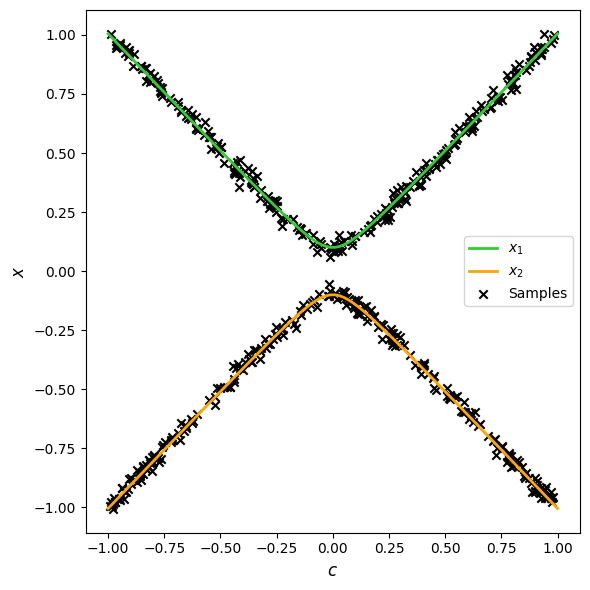

In [4]:
# Apply the rand_mod function to y_circle
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

# # If we want not conflicting data
# num_samples = 500
# x = np.random.uniform(-1, 1, num_samples)
# y = np.array([y_multi(x_i)[0] for x_i in x])

print(x.shape == y.shape)

# Load dataset
batch_size = 32
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

# Generate the global test set
test_x_vals = np.linspace(-1, 1, 100)  # Fixed test x values
test_y_vals = [y_multi(x_i) for x_i in test_x_vals]  # Corresponding true y values
test_y_vals_transposed = list(zip(*test_y_vals))  # Transpose for mode comparison

# Data bounds for counter-sample generation
y_min = torch.tensor([-1])  # Joint y_target limits (radians)
y_max = torch.tensor([1])

# Plot the function and the samples
plt.figure(figsize=(6, 6))
colors = ['limegreen', 'orange']  # Colors for the two modes

for i, (y_val, color) in enumerate(zip(y_vals_transposed, colors)):
    plt.plot(x_vals, y_val, color=color, label=f'$x_{i+1}$', linewidth=2)

plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('$c$', fontsize=12)
plt.ylabel('$x$', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save the figure as a high-resolution image
plt.savefig('2d_geometric_shapes.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

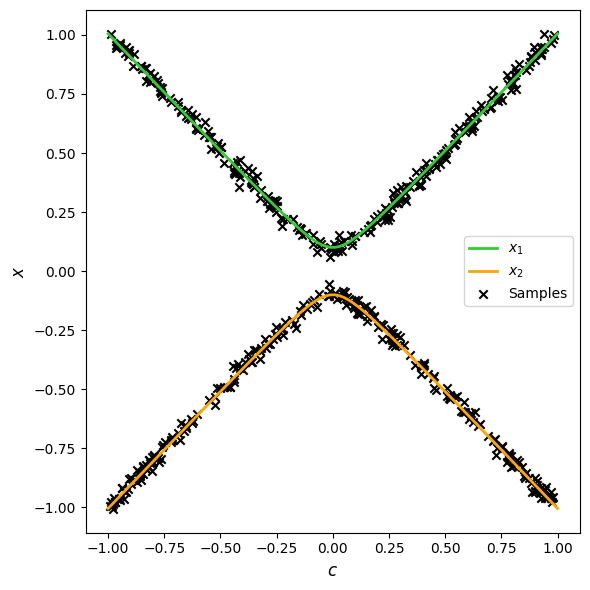

In [5]:
plt.figure(figsize=(6, 6))
colors = ['limegreen', 'orange']  # Colors for the two modes

for i, (test_y_vals, color) in enumerate(zip(test_y_vals_transposed, colors)):
    plt.plot(test_x_vals, test_y_vals, color=color, label=f'$x_{i+1}$', linewidth=2)

plt.scatter(x,y, marker='x', color='black', label='Samples')
plt.xlabel('$c$', fontsize=12)
plt.ylabel('$x$', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save the figure as a high-resolution image
plt.savefig('2d_geometric_shapes.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Evaluation metrics

In [6]:
from scipy.stats import entropy, wasserstein_distance
import random
from methods.ibc import ebm_infer

def compute_metrics(generator, x_test, test_y_vals, y_func, K, model = 'Sampling', num_bins=50, tolerance=0.075, device="cpu"):
    """
    Compute mode coverage, KL divergence, and Wasserstein distance for test data.

    Args:
        generator (torch.nn.Module): The trained generator model.
        x_test (np.array): Input test values.
        test_y_vals (np.array): True y values for the test set (precomputed).
        y_func (function): Function to compute true modes for each x.
        K (int): Number of samples to generate per x.
        num_bins (int): Number of bins for histogram-based metrics.
        tolerance (float): Tolerance for mode matching.
        device (str): Device for computation.

    Returns:
        metrics (dict): Contains mode coverage, KL divergence, and Wasserstein distance.
    """
    # Step 1: Evaluate Mode Coverage and Generate Representative Test Set
    num_inputs = len(x_test)
    avg_modes_cov = 0
    num_modes_covered = 0
    generated_test_y_vals = []  # Store representative generated samples

    for i, x in enumerate(x_test):
        
        # Compute true modes for this x dynamically
        true_modes = np.array(y_func(x))
        
        if model == 'Network':
            # Predict K samples for this x
            x_tensor = torch.tensor([[x]], dtype=torch.float32).repeat(K, 1).to(device)

            generated_samples = generator.forward(x_tensor).detach().cpu().numpy().flatten()
        
        elif model == 'Sampling':
            # Sample K samples for this x
            x_tensor = torch.tensor([[x]], dtype=torch.float32).repeat(K, 1).to(device)
            z = torch.randn(K, generator.latent_size, dtype=torch.float32).to(device)

            generated_samples = generator.sample(z, x_tensor).detach().cpu().numpy().flatten()
        
        elif model == 'Generator':
            # Generate K samples for this x
            x_tensor = torch.tensor([[x]], dtype=torch.float32).repeat(K, 1).to(device)
            z = torch.randn(K, generator.latent_size, dtype=torch.float32).to(device)

            generated_samples = generator.forward(z, x_tensor).detach().cpu().numpy().flatten()
            
        elif model == 'IBC':
            generated_samples = []
            for i in range(K):
                x_tensor = torch.tensor([[x]], dtype=torch.float32).to(device)
                prediction = ebm_infer(generator, x_tensor, y_min.to(device), y_max.to(device))
                generated_samples.append(prediction)
        
        # Check if all true modes are matched within tolerance
        mode_match = [np.any(np.abs(generated_samples - mode) <= tolerance) for mode in true_modes]

        if sum(mode_match) == len(true_modes):  # All modes covered
            num_modes_covered +=  1
        avg_modes_cov +=  sum(mode_match)

        # Append one representative sample for each x to build generated_test_y_vals
        generated_test_y_vals.append(random.choice(generated_samples))  # Representative sample
            

    # Compute mode coverage
    mode_coverage = num_modes_covered / num_inputs *100 
    avg_modes_coverage = avg_modes_cov/ num_inputs
    generated_test_y_vals = np.array(generated_test_y_vals)

    # Step 2: Compute KL Divergence and Wasserstein Distance
    # Flatten test_y_vals and generated_test_y_vals for comparison
    true_y_flat = test_y_vals.flatten()
    generated_y_flat = generated_test_y_vals.flatten()

    # Compute histograms for KL divergence and Wasserstein distance
    hist_true, bins = np.histogram(true_y_flat, bins=num_bins, density=True)
    hist_generated, _ = np.histogram(generated_y_flat, bins=bins, density=True)

    # Smooth histograms to avoid zero probabilities
    hist_true += 1e-8
    hist_generated += 1e-8

    # Normalize histograms
    hist_true /= hist_true.sum()
    hist_generated /= hist_generated.sum()

    # KL Divergence
    kl_div = entropy(hist_true, hist_generated)

    # Wasserstein Distance
    w_distance = wasserstein_distance(hist_true, hist_generated)

    # Return metrics
    return {
        "Mode Coverage (%)": mode_coverage,
        "Avgerage Modes coveraged": avg_modes_coverage,
        "KL Divergence": kl_div,
        "Wasserstein Distance": w_distance,
    }



In [7]:
NUM_TRIALS = 5
TOLERANCE = 0.07

# Problem set-up Parameter


In [8]:
input_size = 1  # x, y x_input
action_size = 1  # joint y_target
condition_size = 1
output_size = 1

# EBGAN-MDN

Hyperparameter

# Tests

In [9]:
# Initialize a new MDN generator
from methods.ebgan import EnergyModel,  generate_counter_samples
from methods.mdn import MDNGenerator, mdn_loss

In [22]:
def evaluate_model(energy_model, generator, epoch, latent_size, device, id = 0):
    # Generate grid points within the range of x values
    x_range = np.linspace(-1, 1, 100)
    y_range = np.linspace(-1, 1, 100)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

    # Compute energy model output for each grid point
    energy_outputs = energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
    energy_outputs = energy_outputs.reshape(100, 100)

    # Normalize every column of the heatmap
    energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))

    # Plot the heatmap and the function, samples, and predictions in the same figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the heatmap
    heatmap = ax.imshow(energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.5)

    # Plot the samples
    ax.scatter(x, y, marker='x', color='black', label='Original samples')

    # Random sample the query points and get the predictions using mdn_generator
    num_query_points = 200
    query_points = np.linspace(-1, 1, num_query_points)
    query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)
    z = torch.randn(num_query_points, latent_size).to(device)

    # Generate samples from the mixture model
    predictions_mdn = generator.sample(z, query_points_tensor).detach().cpu().numpy()

    # Plot the MDN generator predictions
    ax.scatter(query_points, predictions_mdn, marker='o', color='red', label='MDN Generator Predictions', alpha=0.9)

    # Set limits to cut the plot within -1, 1
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_xlabel('c')
    ax.set_ylabel('x')
    ax.grid()
    ax.legend()
    # plt.title(f"Evaluation at Epoch {epoch}")
    plt.savefig(f'images/benchmark_generator/EBM_MDN_{id}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [23]:
from methods.ebgan_mdn import train_ebgan_mdn

def train_and_evaluate(num_trials, dataloader, test_x_vals, test_y_vals_transposed, 
                       num_epochs, y_min, y_max, 
                       neg_count, repeat_energy_updates, device, alpha, dynamic_scaling_true, min_scale, y_multi,
                       latent_size, hidden_size, num_gaussians, learning_rate_e, learning_rate_g
                       ):
    results = {"KL Divergence": [], "Wasserstein Distance": [], "Mode Coverage (%)": [], "Avgerage Modes coveraged": []}

    for trial in range(num_trials):
        print(f"\n=== Training Run {trial + 1} ===")
        
        ebgan_mdn_generator = MDNGenerator(latent_size, hidden_size, output_size, num_gaussians, condition_size).to(device)
        ebgan_energy_model = EnergyModel(condition_size, output_size, hidden_size).to(device)

        # Optimizer
        optimizer_ebgan_e = optim.Adam(ebgan_energy_model.parameters(), lr=learning_rate_e)
        optimizer_ebgan_g = optim.Adam(ebgan_mdn_generator.parameters(), lr=learning_rate_g)
        scheduler_e = optim.lr_scheduler.StepLR(optimizer_ebgan_e, step_size=20, gamma=0.5)
        scheduler_g = optim.lr_scheduler.StepLR(optimizer_ebgan_g, step_size=20, gamma=0.5)
        
        # Train the model
        train_ebgan_mdn(dataloader, ebgan_energy_model, ebgan_mdn_generator, optimizer_ebgan_e, optimizer_ebgan_g, 
                        scheduler_e, scheduler_g, num_epochs, None, y_min, y_max, neg_count, 
                        repeat_energy_updates, device, alpha, dynamic_scaling_true, min_scale)

        # Flatten the true test y values for metric computation
        true_y_flat = np.array(test_y_vals_transposed).reshape(-1, len(test_x_vals)).T

        # Compute metrics  
        metrics = compute_metrics(ebgan_mdn_generator, test_x_vals, true_y_flat , y_multi, K = 10, num_bins=50, tolerance=TOLERANCE)
        for key in results.keys():
            results[key].append(metrics[key])

        print(f"Run {trial + 1} - KL Divergence: {metrics["KL Divergence"]:.4f}, Wasserstein Distance: {metrics["Wasserstein Distance"]:.4f}, Mode Coverage (%): {metrics["Mode Coverage (%)"]}, Avgerage Modes coveraged: {metrics["Avgerage Modes coveraged"]}")
        
        evaluate_model(ebgan_energy_model, ebgan_mdn_generator, num_epochs, ebgan_mdn_generator.latent_size, device, trial)
    # Compute averages and standard deviations
    for metric, values in results.items():
        avg = np.mean(values)
        std = np.std(values)
        print(f"{metric}: {avg:.4f} ± {std:.4f}")

    return results


# Standard Generator Inclusion

In [28]:
# Hyperparameters
num_gaussians = 2

latent_size = 1
hidden_size = 64

num_epochs = 100
batch_size = 32

neg_count = 32
repeat_energy_updates = 5

learning_rate_e = 0.001
learning_rate_g = 0.0005

epoch_num_eval = 100

# Configuration parameter 
alpha = 1
dynamic_scaling_true = False
min_scale = 0.1


=== Training Run 1 ===
Epoch [1/100], Energy Loss: 3.4754, Generator Loss: -0.1311, Generator Energy Loss: -0.2114, Generator MDN Loss: 0.0803
Epoch [2/100], Energy Loss: 3.2633, Generator Loss: -0.4606, Generator Energy Loss: -0.4842, Generator MDN Loss: 0.0236
Epoch [3/100], Energy Loss: 2.9160, Generator Loss: -0.9160, Generator Energy Loss: -0.9382, Generator MDN Loss: 0.0222
Epoch [4/100], Energy Loss: 2.6269, Generator Loss: -1.6078, Generator Energy Loss: -1.6071, Generator MDN Loss: -0.0006
Epoch [5/100], Energy Loss: 2.4386, Generator Loss: -1.8418, Generator Energy Loss: -1.8362, Generator MDN Loss: -0.0055
Epoch [6/100], Energy Loss: 2.3494, Generator Loss: -1.9170, Generator Energy Loss: -1.8980, Generator MDN Loss: -0.0190
Epoch [7/100], Energy Loss: 2.1843, Generator Loss: -1.7770, Generator Energy Loss: -1.7303, Generator MDN Loss: -0.0467
Epoch [8/100], Energy Loss: 2.0964, Generator Loss: -1.8321, Generator Energy Loss: -1.7751, Generator MDN Loss: -0.0570
Epoch [9/10

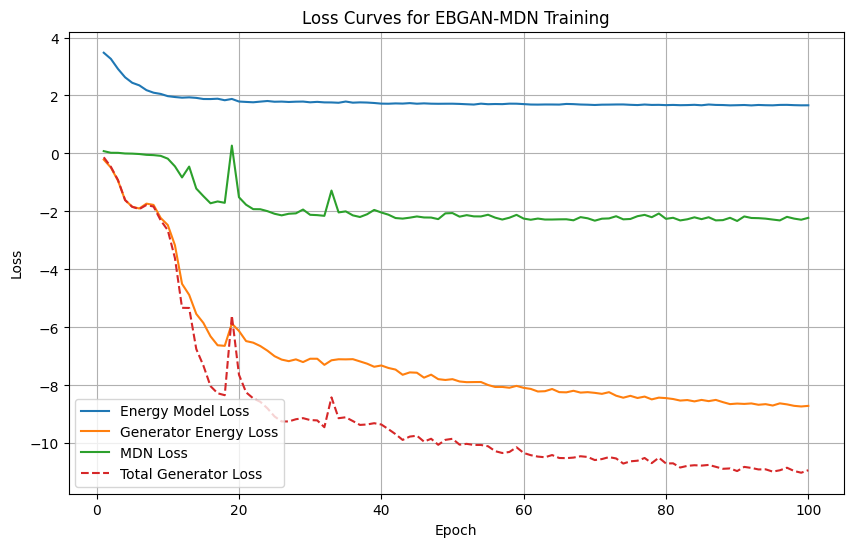

Run 1 - KL Divergence: 1.0174, Wasserstein Distance: 0.0052, Mode Coverage (%): 99.0, Avgerage Modes coveraged: 1.99


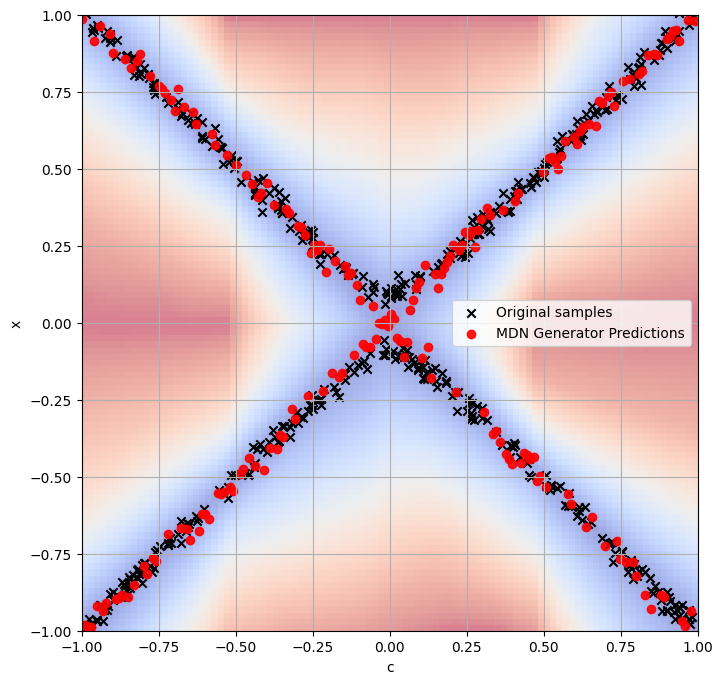


=== Training Run 2 ===
Epoch [1/100], Energy Loss: 3.4846, Generator Loss: 0.3215, Generator Energy Loss: 0.2178, Generator MDN Loss: 0.1038
Epoch [2/100], Energy Loss: 3.2761, Generator Loss: 0.3393, Generator Energy Loss: 0.3186, Generator MDN Loss: 0.0207
Epoch [3/100], Energy Loss: 2.8673, Generator Loss: 0.4464, Generator Energy Loss: 0.4284, Generator MDN Loss: 0.0180
Epoch [4/100], Energy Loss: 2.5263, Generator Loss: 0.5254, Generator Energy Loss: 0.5172, Generator MDN Loss: 0.0081
Epoch [5/100], Energy Loss: 2.3144, Generator Loss: 0.7065, Generator Energy Loss: 0.7105, Generator MDN Loss: -0.0041
Epoch [6/100], Energy Loss: 2.2330, Generator Loss: 1.5031, Generator Energy Loss: 1.5234, Generator MDN Loss: -0.0203
Epoch [7/100], Energy Loss: 2.1722, Generator Loss: 2.0741, Generator Energy Loss: 2.1206, Generator MDN Loss: -0.0466
Epoch [8/100], Energy Loss: 2.0050, Generator Loss: 1.7194, Generator Energy Loss: 1.8669, Generator MDN Loss: -0.1475
Epoch [9/100], Energy Loss: 

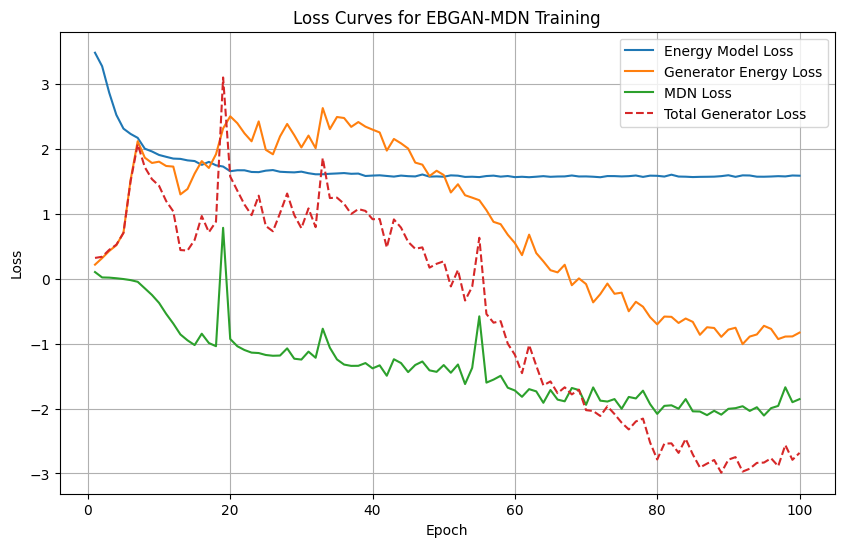

Run 2 - KL Divergence: 1.6742, Wasserstein Distance: 0.0086, Mode Coverage (%): 97.0, Avgerage Modes coveraged: 1.97


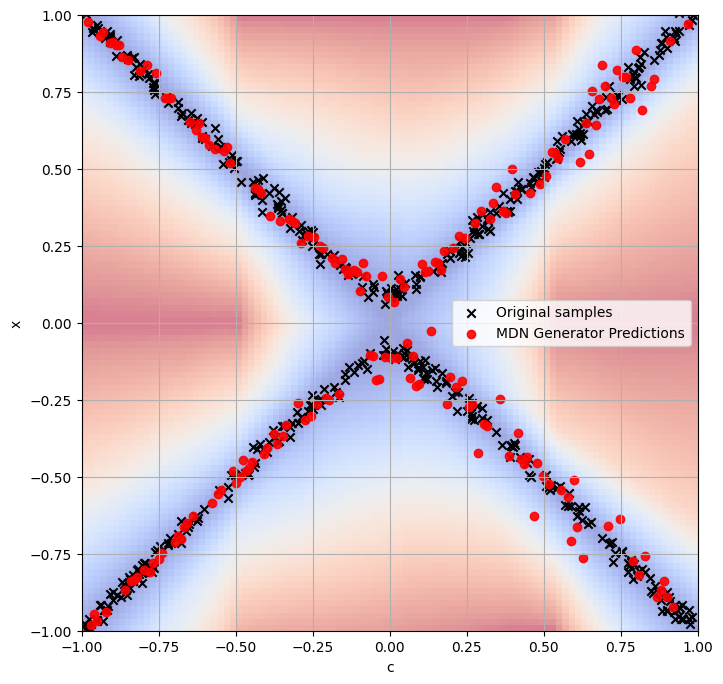


=== Training Run 3 ===
Epoch [1/100], Energy Loss: 3.4854, Generator Loss: 0.0870, Generator Energy Loss: -0.0076, Generator MDN Loss: 0.0946
Epoch [2/100], Energy Loss: 3.2930, Generator Loss: 0.2791, Generator Energy Loss: 0.2451, Generator MDN Loss: 0.0340
Epoch [3/100], Energy Loss: 3.0075, Generator Loss: 0.7560, Generator Energy Loss: 0.7428, Generator MDN Loss: 0.0132
Epoch [4/100], Energy Loss: 2.7901, Generator Loss: 1.5135, Generator Energy Loss: 1.5147, Generator MDN Loss: -0.0012
Epoch [5/100], Energy Loss: 2.5911, Generator Loss: 2.1619, Generator Energy Loss: 2.1712, Generator MDN Loss: -0.0093
Epoch [6/100], Energy Loss: 2.4019, Generator Loss: 3.1680, Generator Energy Loss: 3.1864, Generator MDN Loss: -0.0183
Epoch [7/100], Energy Loss: 2.3110, Generator Loss: 3.6689, Generator Energy Loss: 3.7390, Generator MDN Loss: -0.0702
Epoch [8/100], Energy Loss: 2.1990, Generator Loss: 4.1324, Generator Energy Loss: 4.2385, Generator MDN Loss: -0.1061
Epoch [9/100], Energy Loss

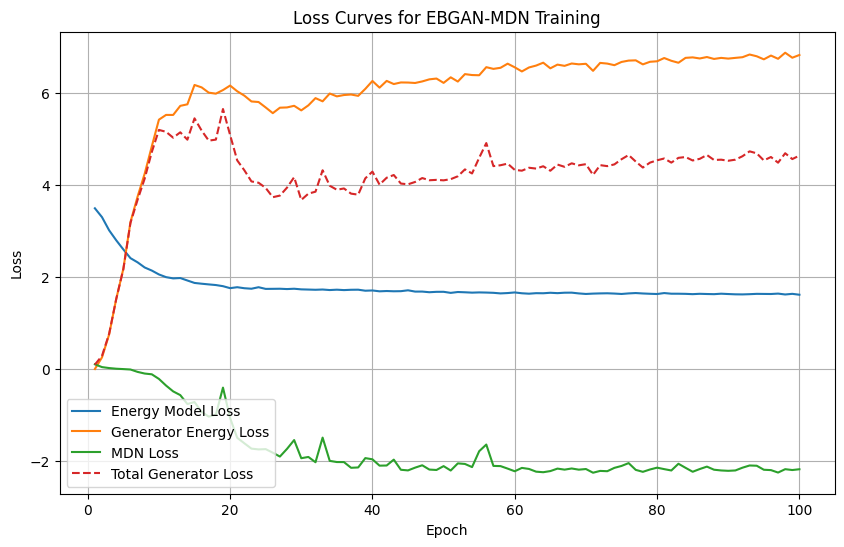

Run 3 - KL Divergence: 2.7174, Wasserstein Distance: 0.0071, Mode Coverage (%): 98.0, Avgerage Modes coveraged: 1.98


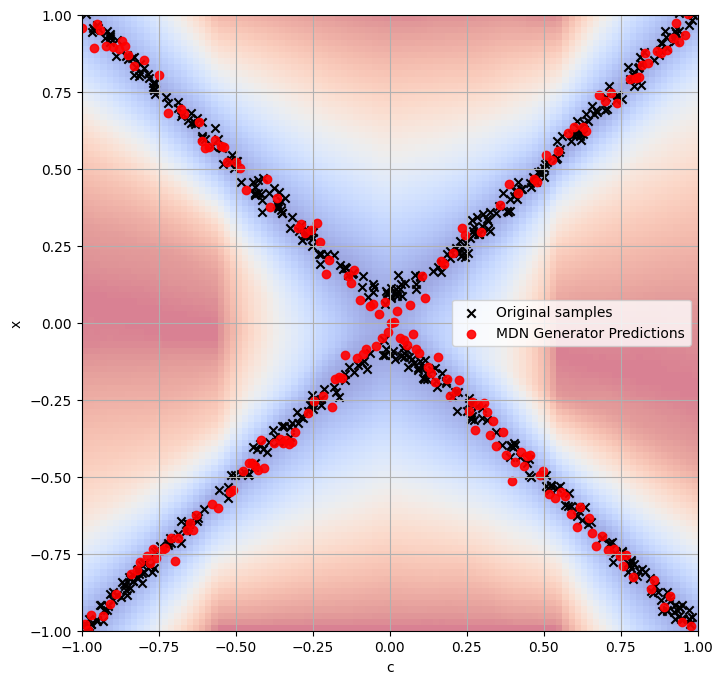


=== Training Run 4 ===
Epoch [1/100], Energy Loss: 3.4936, Generator Loss: 0.3425, Generator Energy Loss: 0.2054, Generator MDN Loss: 0.1371
Epoch [2/100], Energy Loss: 3.3303, Generator Loss: 0.4354, Generator Energy Loss: 0.4034, Generator MDN Loss: 0.0319
Epoch [3/100], Energy Loss: 3.0113, Generator Loss: 0.5849, Generator Energy Loss: 0.5637, Generator MDN Loss: 0.0213
Epoch [4/100], Energy Loss: 2.6915, Generator Loss: 1.0513, Generator Energy Loss: 1.0487, Generator MDN Loss: 0.0025
Epoch [5/100], Energy Loss: 2.4444, Generator Loss: 1.7429, Generator Energy Loss: 1.7510, Generator MDN Loss: -0.0081
Epoch [6/100], Energy Loss: 2.2776, Generator Loss: 2.3268, Generator Energy Loss: 2.3373, Generator MDN Loss: -0.0105
Epoch [7/100], Energy Loss: 2.1547, Generator Loss: 2.7861, Generator Energy Loss: 2.8767, Generator MDN Loss: -0.0907
Epoch [8/100], Energy Loss: 2.0742, Generator Loss: 2.8636, Generator Energy Loss: 3.0665, Generator MDN Loss: -0.2030
Epoch [9/100], Energy Loss: 

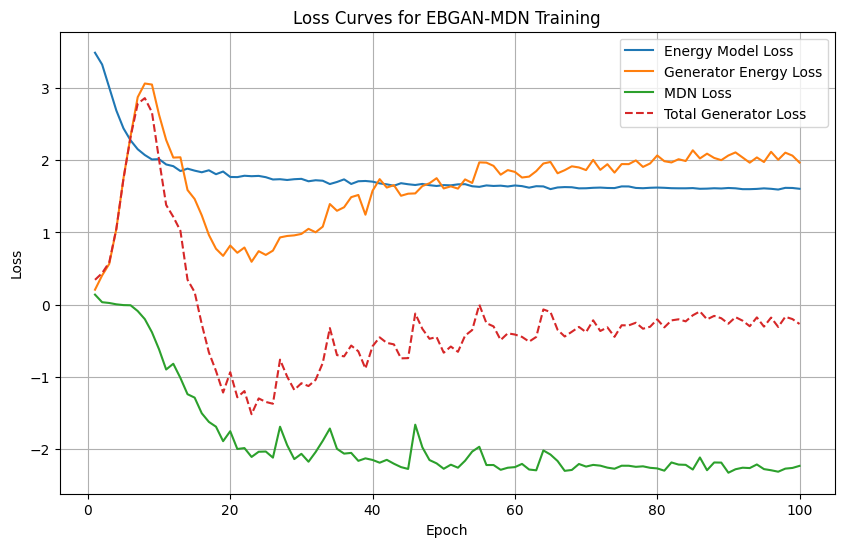

Run 4 - KL Divergence: 1.7043, Wasserstein Distance: 0.0052, Mode Coverage (%): 97.0, Avgerage Modes coveraged: 1.97


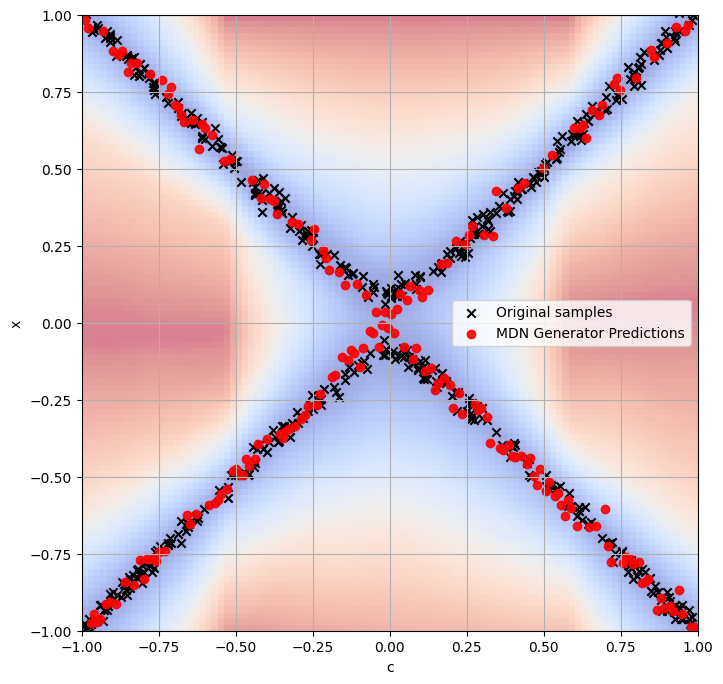


=== Training Run 5 ===
Epoch [1/100], Energy Loss: 3.4851, Generator Loss: 0.2834, Generator Energy Loss: 0.1414, Generator MDN Loss: 0.1420
Epoch [2/100], Energy Loss: 3.2780, Generator Loss: 0.2321, Generator Energy Loss: 0.1849, Generator MDN Loss: 0.0473
Epoch [3/100], Energy Loss: 2.9043, Generator Loss: 0.4463, Generator Energy Loss: 0.4311, Generator MDN Loss: 0.0152
Epoch [4/100], Energy Loss: 2.5759, Generator Loss: 1.0985, Generator Energy Loss: 1.0648, Generator MDN Loss: 0.0337
Epoch [5/100], Energy Loss: 2.3586, Generator Loss: 1.4994, Generator Energy Loss: 1.4620, Generator MDN Loss: 0.0374
Epoch [6/100], Energy Loss: 2.2341, Generator Loss: 2.3838, Generator Energy Loss: 2.3853, Generator MDN Loss: -0.0015
Epoch [7/100], Energy Loss: 2.1164, Generator Loss: 2.8929, Generator Energy Loss: 2.9047, Generator MDN Loss: -0.0119
Epoch [8/100], Energy Loss: 2.0170, Generator Loss: 3.1277, Generator Energy Loss: 3.2207, Generator MDN Loss: -0.0930
Epoch [9/100], Energy Loss: 1

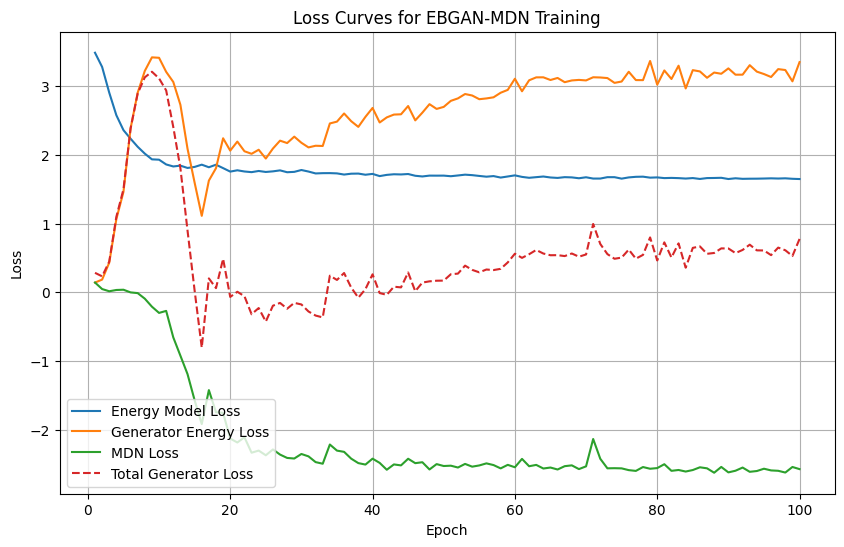

Run 5 - KL Divergence: 2.0200, Wasserstein Distance: 0.0087, Mode Coverage (%): 99.0, Avgerage Modes coveraged: 1.99


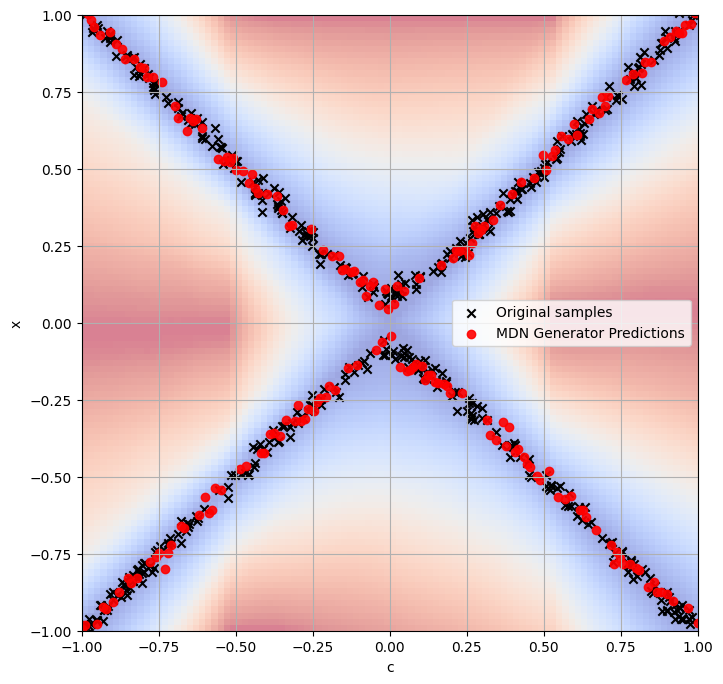

KL Divergence: 1.8267 ± 0.5521
Wasserstein Distance: 0.0070 ± 0.0016
Mode Coverage (%): 98.0000 ± 0.8944
Avgerage Modes coveraged: 1.9800 ± 0.0089


In [29]:
metrics_results = train_and_evaluate(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_min=y_min,
    y_max=y_max,
    neg_count=neg_count,
    repeat_energy_updates=repeat_energy_updates,
    device=device,
    alpha=alpha,
    dynamic_scaling_true=dynamic_scaling_true,
    min_scale=min_scale,
    y_multi = y_multi,
    latent_size = latent_size,
    hidden_size = hidden_size,
    num_gaussians = num_gaussians,
    learning_rate_e = learning_rate_e,
    learning_rate_g = learning_rate_g
)

## Dynamic Scaling

In [37]:
# Hyperparameters
num_gaussians = 2

latent_size = 1
hidden_size = 64

num_epochs = 100
batch_size = 32

neg_count = 32
repeat_energy_updates = 5

learning_rate_e = 0.001
learning_rate_g = 0.0005

epoch_num_eval = 100

# Configuration parameter 
alpha = 1
dynamic_scaling_true = True
min_scale = 0.1


=== Training Run 1 ===
Epoch [1/100], Energy Loss: 3.4726, Generator Loss: 0.1140, Generator Energy Loss: -0.0637, Generator MDN Loss: 0.1777
Epoch [2/100], Energy Loss: 3.2527, Generator Loss: 0.2117, Generator Energy Loss: 0.1159, Generator MDN Loss: 0.0958
Epoch [3/100], Energy Loss: 2.9306, Generator Loss: 0.3846, Generator Energy Loss: 0.3478, Generator MDN Loss: 0.0367
Epoch [4/100], Energy Loss: 2.6582, Generator Loss: 0.7101, Generator Energy Loss: 0.6895, Generator MDN Loss: 0.0207
Epoch [5/100], Energy Loss: 2.4996, Generator Loss: 0.5822, Generator Energy Loss: 0.5842, Generator MDN Loss: -0.0020
Epoch [6/100], Energy Loss: 2.3144, Generator Loss: 0.5378, Generator Energy Loss: 0.5738, Generator MDN Loss: -0.0360
Epoch [7/100], Energy Loss: 2.2265, Generator Loss: 0.3483, Generator Energy Loss: 0.4367, Generator MDN Loss: -0.0884
Epoch [8/100], Energy Loss: 2.1169, Generator Loss: -0.0339, Generator Energy Loss: 0.0372, Generator MDN Loss: -0.0711
Epoch [9/100], Energy Loss

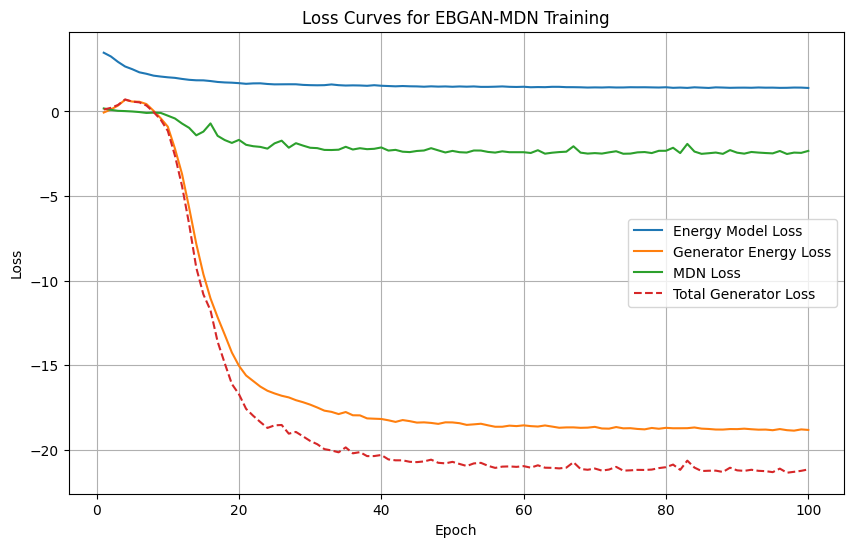

Run 1 - KL Divergence: 1.1236, Wasserstein Distance: 0.0067, Mode Coverage (%): 99.0, Avgerage Modes coveraged: 1.99


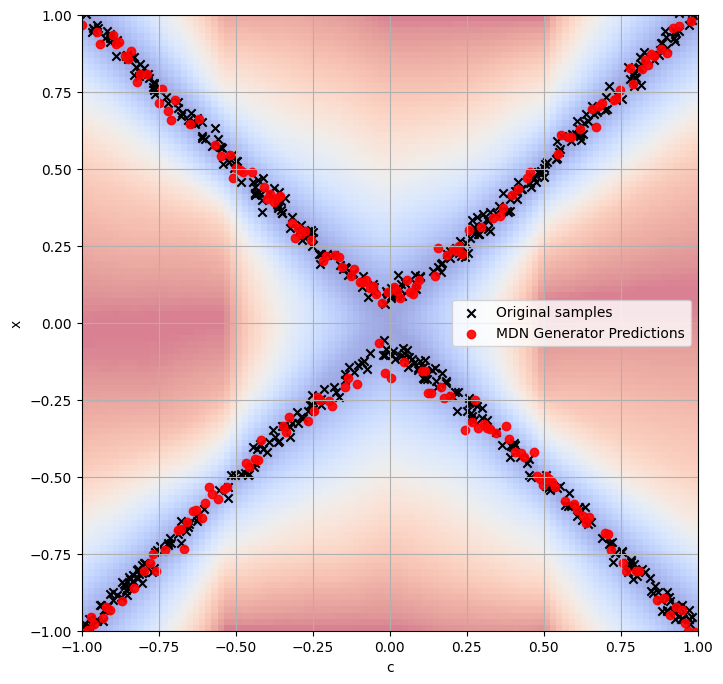


=== Training Run 2 ===
Epoch [1/100], Energy Loss: 3.4929, Generator Loss: 0.0800, Generator Energy Loss: -0.0423, Generator MDN Loss: 0.1224
Epoch [2/100], Energy Loss: 3.3253, Generator Loss: -0.1228, Generator Energy Loss: -0.1638, Generator MDN Loss: 0.0410
Epoch [3/100], Energy Loss: 3.0221, Generator Loss: -0.1295, Generator Energy Loss: -0.1459, Generator MDN Loss: 0.0164
Epoch [4/100], Energy Loss: 2.7303, Generator Loss: -0.4438, Generator Energy Loss: -0.4441, Generator MDN Loss: 0.0003
Epoch [5/100], Energy Loss: 2.5075, Generator Loss: -0.1898, Generator Energy Loss: -0.1765, Generator MDN Loss: -0.0133
Epoch [6/100], Energy Loss: 2.3654, Generator Loss: -0.3242, Generator Energy Loss: -0.2783, Generator MDN Loss: -0.0459
Epoch [7/100], Energy Loss: 2.2270, Generator Loss: -0.4734, Generator Energy Loss: -0.4199, Generator MDN Loss: -0.0535
Epoch [8/100], Energy Loss: 2.1300, Generator Loss: -0.6913, Generator Energy Loss: -0.6051, Generator MDN Loss: -0.0862
Epoch [9/100]

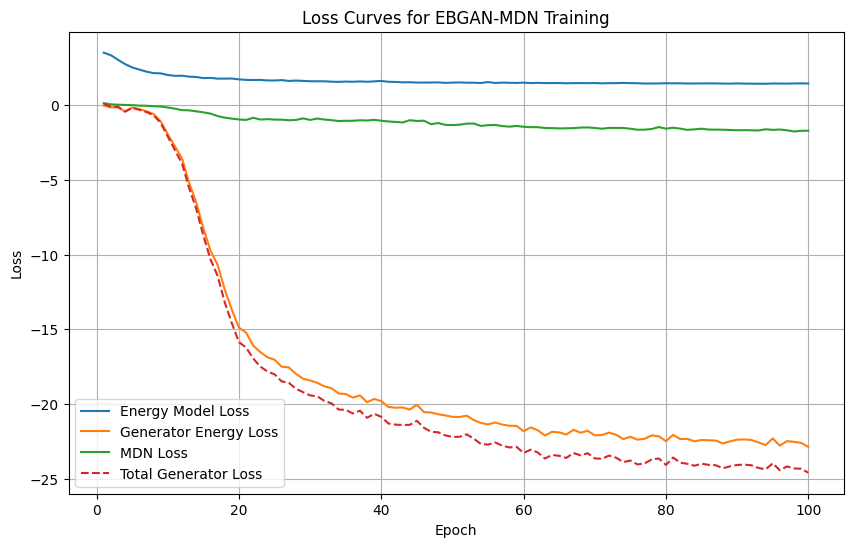

Run 2 - KL Divergence: 1.5895, Wasserstein Distance: 0.0071, Mode Coverage (%): 85.0, Avgerage Modes coveraged: 1.85


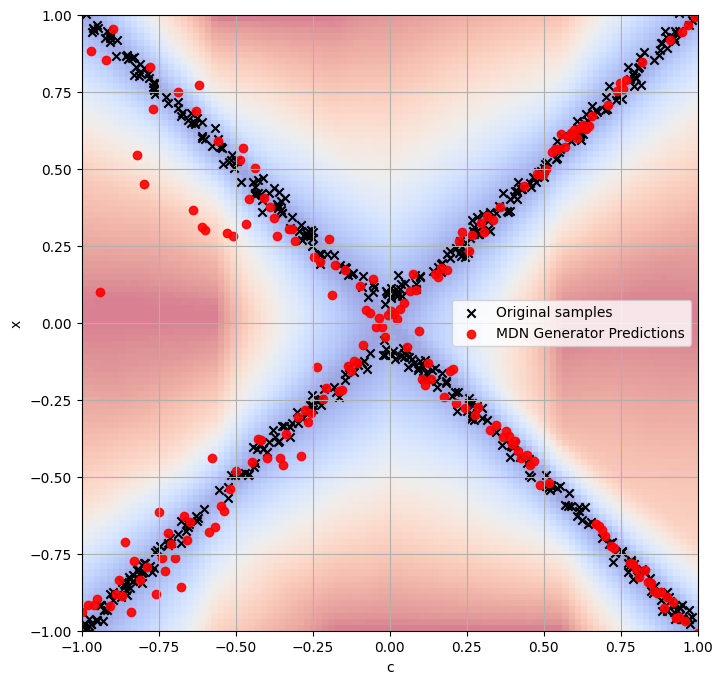


=== Training Run 3 ===
Epoch [1/100], Energy Loss: 3.4703, Generator Loss: 0.2122, Generator Energy Loss: 0.0253, Generator MDN Loss: 0.1869
Epoch [2/100], Energy Loss: 3.2241, Generator Loss: 0.2759, Generator Energy Loss: 0.2140, Generator MDN Loss: 0.0619
Epoch [3/100], Energy Loss: 2.8601, Generator Loss: 0.8158, Generator Energy Loss: 0.7935, Generator MDN Loss: 0.0222
Epoch [4/100], Energy Loss: 2.5840, Generator Loss: 1.4419, Generator Energy Loss: 1.4389, Generator MDN Loss: 0.0030
Epoch [5/100], Energy Loss: 2.4002, Generator Loss: 1.8058, Generator Energy Loss: 1.8079, Generator MDN Loss: -0.0021
Epoch [6/100], Energy Loss: 2.2885, Generator Loss: 2.3207, Generator Energy Loss: 2.3355, Generator MDN Loss: -0.0148
Epoch [7/100], Energy Loss: 2.2260, Generator Loss: 2.5991, Generator Energy Loss: 2.6887, Generator MDN Loss: -0.0896
Epoch [8/100], Energy Loss: 2.1357, Generator Loss: 2.6633, Generator Energy Loss: 2.8257, Generator MDN Loss: -0.1625
Epoch [9/100], Energy Loss: 

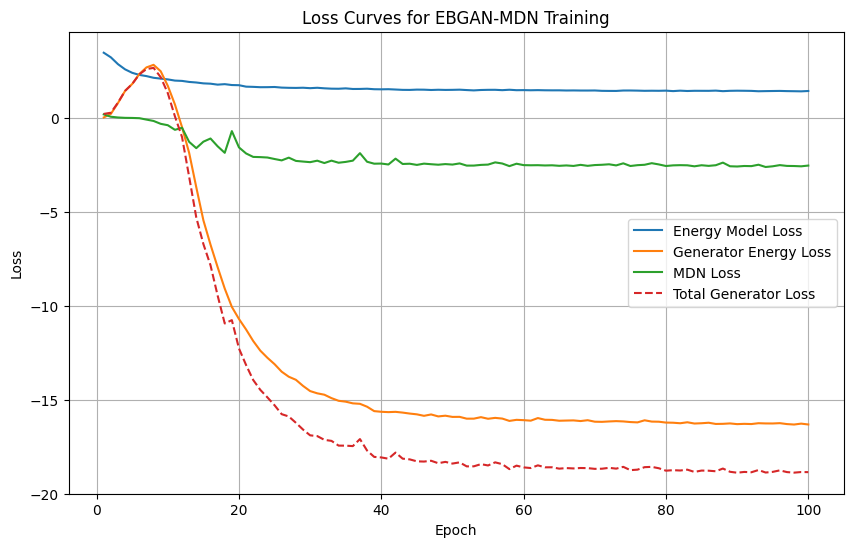

Run 3 - KL Divergence: 1.9392, Wasserstein Distance: 0.0071, Mode Coverage (%): 100.0, Avgerage Modes coveraged: 2.0


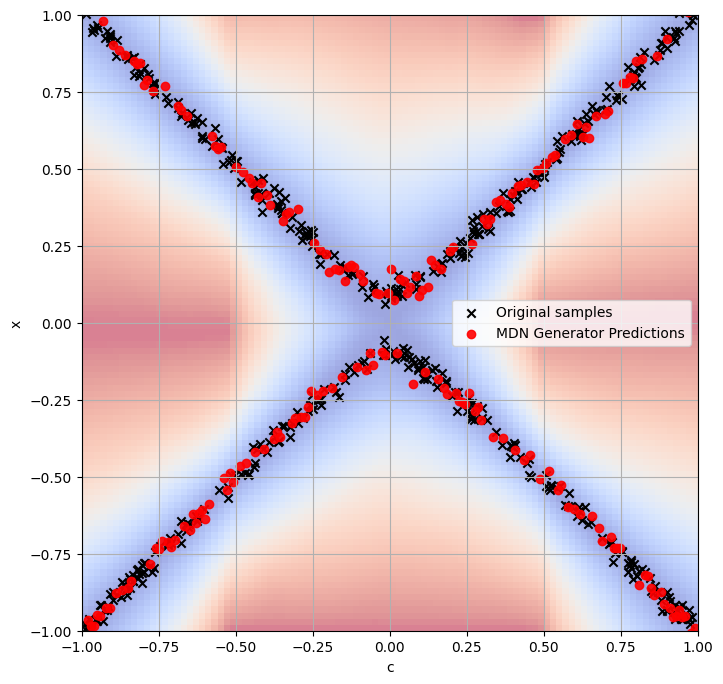


=== Training Run 4 ===
Epoch [1/100], Energy Loss: 3.4822, Generator Loss: -0.0765, Generator Energy Loss: -0.1979, Generator MDN Loss: 0.1215
Epoch [2/100], Energy Loss: 3.2645, Generator Loss: -0.3877, Generator Energy Loss: -0.4384, Generator MDN Loss: 0.0507
Epoch [3/100], Energy Loss: 2.9106, Generator Loss: -0.9108, Generator Energy Loss: -0.9292, Generator MDN Loss: 0.0183
Epoch [4/100], Energy Loss: 2.6854, Generator Loss: -0.9208, Generator Energy Loss: -0.9291, Generator MDN Loss: 0.0083
Epoch [5/100], Energy Loss: 2.4545, Generator Loss: -1.0800, Generator Energy Loss: -1.0816, Generator MDN Loss: 0.0016
Epoch [6/100], Energy Loss: 2.3014, Generator Loss: -1.4428, Generator Energy Loss: -1.4378, Generator MDN Loss: -0.0050
Epoch [7/100], Energy Loss: 2.2005, Generator Loss: -1.6672, Generator Energy Loss: -1.6524, Generator MDN Loss: -0.0149
Epoch [8/100], Energy Loss: 2.0910, Generator Loss: -1.9910, Generator Energy Loss: -1.9675, Generator MDN Loss: -0.0235
Epoch [9/100]

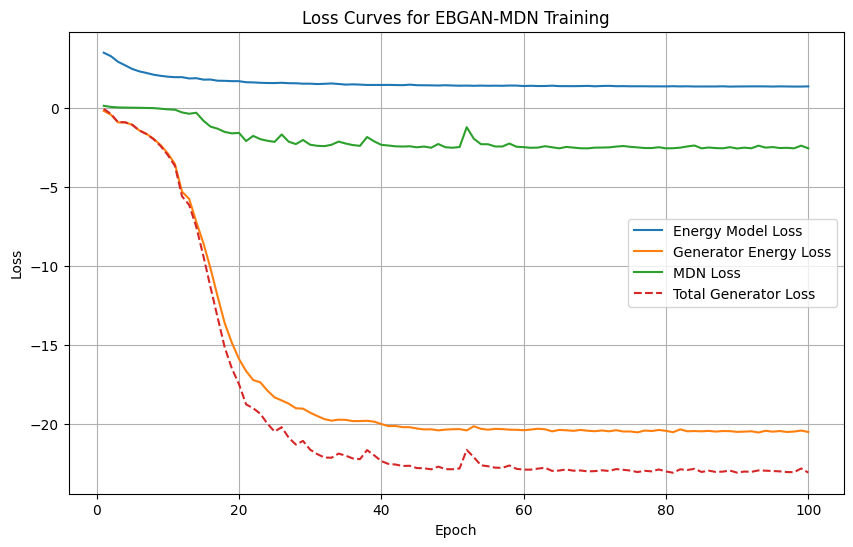

Run 4 - KL Divergence: 1.4590, Wasserstein Distance: 0.0056, Mode Coverage (%): 99.0, Avgerage Modes coveraged: 1.99


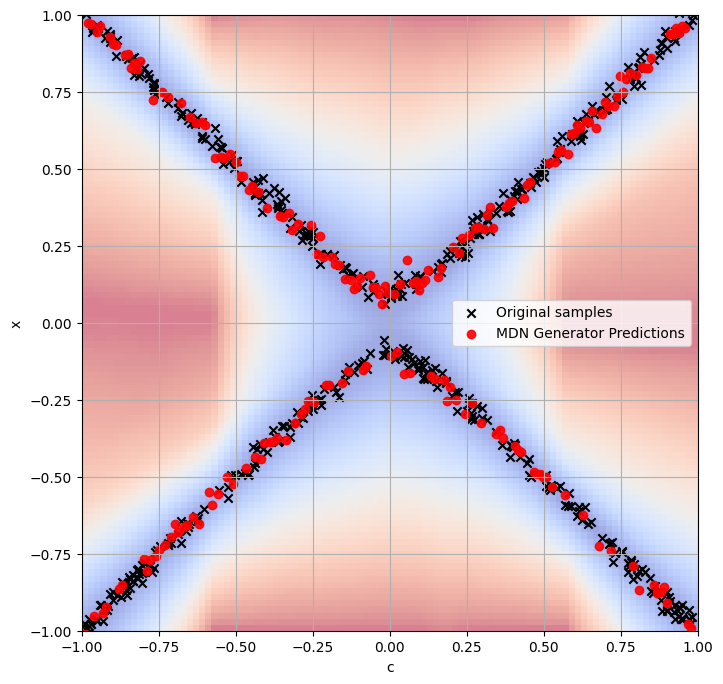


=== Training Run 5 ===
Epoch [1/100], Energy Loss: 3.4995, Generator Loss: 0.0066, Generator Energy Loss: -0.1427, Generator MDN Loss: 0.1493
Epoch [2/100], Energy Loss: 3.3828, Generator Loss: -0.2804, Generator Energy Loss: -0.3408, Generator MDN Loss: 0.0604
Epoch [3/100], Energy Loss: 3.1559, Generator Loss: -0.7679, Generator Energy Loss: -0.7939, Generator MDN Loss: 0.0260
Epoch [4/100], Energy Loss: 2.8938, Generator Loss: -1.3570, Generator Energy Loss: -1.3752, Generator MDN Loss: 0.0181
Epoch [5/100], Energy Loss: 2.6642, Generator Loss: -2.2456, Generator Energy Loss: -2.2528, Generator MDN Loss: 0.0072
Epoch [6/100], Energy Loss: 2.4942, Generator Loss: -3.0871, Generator Energy Loss: -3.0713, Generator MDN Loss: -0.0158
Epoch [7/100], Energy Loss: 2.3646, Generator Loss: -3.7149, Generator Energy Loss: -3.6634, Generator MDN Loss: -0.0515
Epoch [8/100], Energy Loss: 2.2503, Generator Loss: -5.1867, Generator Energy Loss: -5.0350, Generator MDN Loss: -0.1517
Epoch [9/100],

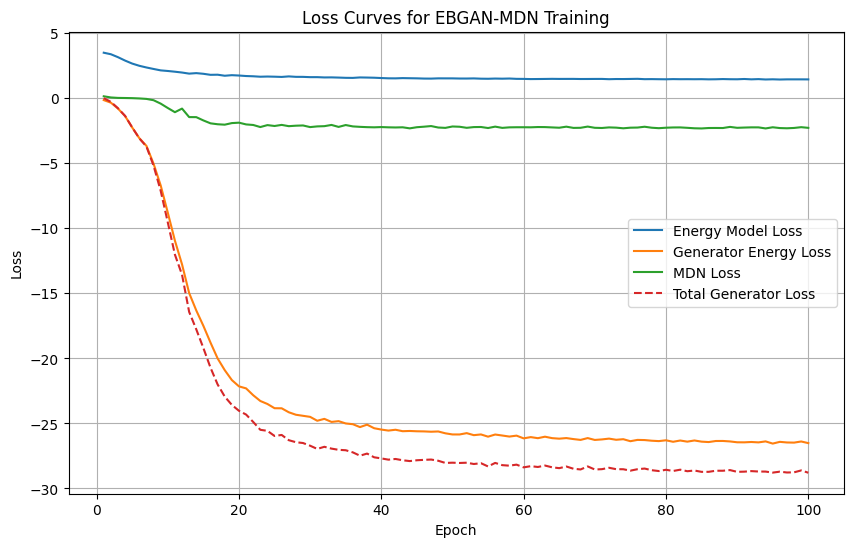

Run 5 - KL Divergence: 2.3556, Wasserstein Distance: 0.0064, Mode Coverage (%): 98.0, Avgerage Modes coveraged: 1.97


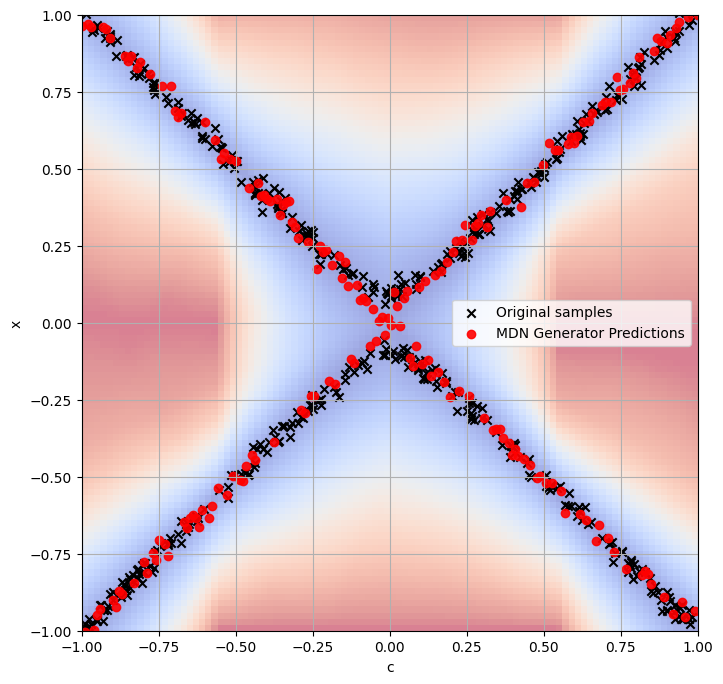

KL Divergence: 1.6934 ± 0.4217
Wasserstein Distance: 0.0066 ± 0.0006
Mode Coverage (%): 96.2000 ± 5.6356
Avgerage Modes coveraged: 1.9600 ± 0.0559


In [38]:
metrics_results = train_and_evaluate(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_min=y_min,
    y_max=y_max,
    neg_count=neg_count,
    repeat_energy_updates=repeat_energy_updates,
    device=device,
    alpha=alpha,
    dynamic_scaling_true=dynamic_scaling_true,
    min_scale=min_scale,
    y_multi = y_multi,
    latent_size = latent_size,
    hidden_size = hidden_size,
    num_gaussians = num_gaussians,
    learning_rate_e = learning_rate_e,
    learning_rate_g = learning_rate_g
)

## Removing the Generator Term


=== Training Run 1 ===
Epoch [1/100], Energy Loss: 3.4725, Generator Loss: -0.2565, Generator Energy Loss: -0.4492, Generator MDN Loss: 0.1927
Epoch [2/100], Energy Loss: 3.2894, Generator Loss: -1.2445, Generator Energy Loss: -1.3315, Generator MDN Loss: 0.0869
Epoch [3/100], Energy Loss: 3.0242, Generator Loss: -2.0257, Generator Energy Loss: -2.0726, Generator MDN Loss: 0.0469
Epoch [4/100], Energy Loss: 2.7657, Generator Loss: -2.2116, Generator Energy Loss: -2.2331, Generator MDN Loss: 0.0215
Epoch [5/100], Energy Loss: 2.6009, Generator Loss: -2.2988, Generator Energy Loss: -2.2981, Generator MDN Loss: -0.0007
Epoch [6/100], Energy Loss: 2.4483, Generator Loss: -2.3876, Generator Energy Loss: -2.3667, Generator MDN Loss: -0.0209
Epoch [7/100], Energy Loss: 2.3124, Generator Loss: -2.4046, Generator Energy Loss: -2.3746, Generator MDN Loss: -0.0300
Epoch [8/100], Energy Loss: 2.2089, Generator Loss: -2.4211, Generator Energy Loss: -2.3478, Generator MDN Loss: -0.0733
Epoch [9/100

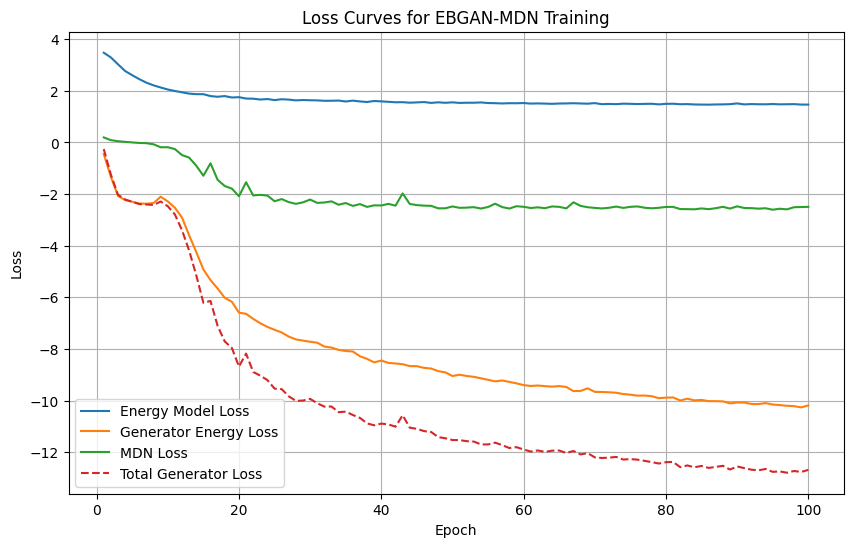

Run 1 - KL Divergence: 1.8090, Wasserstein Distance: 0.0072, Mode Coverage (%): 100.0, Avgerage Modes coveraged: 2.0


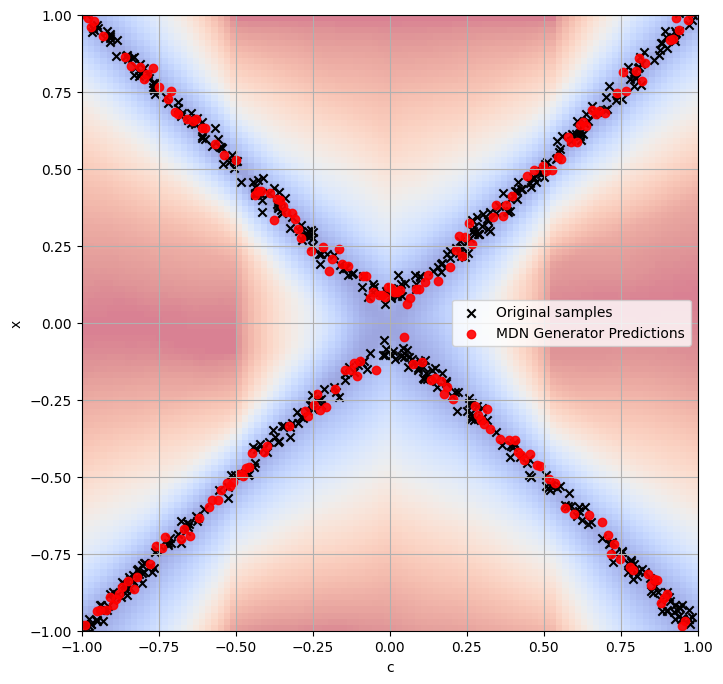


=== Training Run 2 ===
Epoch [1/100], Energy Loss: 3.4818, Generator Loss: -0.2995, Generator Energy Loss: -0.4486, Generator MDN Loss: 0.1492
Epoch [2/100], Energy Loss: 3.3110, Generator Loss: -1.5426, Generator Energy Loss: -1.6179, Generator MDN Loss: 0.0752
Epoch [3/100], Energy Loss: 3.0781, Generator Loss: -2.5579, Generator Energy Loss: -2.6137, Generator MDN Loss: 0.0557
Epoch [4/100], Energy Loss: 2.8459, Generator Loss: -2.9507, Generator Energy Loss: -3.0245, Generator MDN Loss: 0.0738
Epoch [5/100], Energy Loss: 2.6933, Generator Loss: -2.8320, Generator Energy Loss: -2.9016, Generator MDN Loss: 0.0697
Epoch [6/100], Energy Loss: 2.5259, Generator Loss: -2.9152, Generator Energy Loss: -2.9514, Generator MDN Loss: 0.0362
Epoch [7/100], Energy Loss: 2.3926, Generator Loss: -2.6525, Generator Energy Loss: -2.6648, Generator MDN Loss: 0.0123
Epoch [8/100], Energy Loss: 2.2761, Generator Loss: -2.7365, Generator Energy Loss: -2.7182, Generator MDN Loss: -0.0183
Epoch [9/100], 

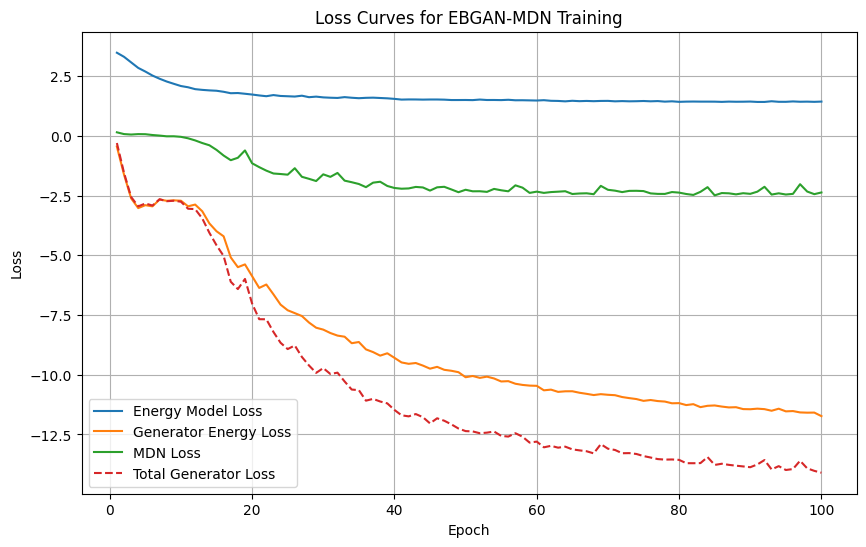

Run 2 - KL Divergence: 1.8014, Wasserstein Distance: 0.0078, Mode Coverage (%): 100.0, Avgerage Modes coveraged: 2.0


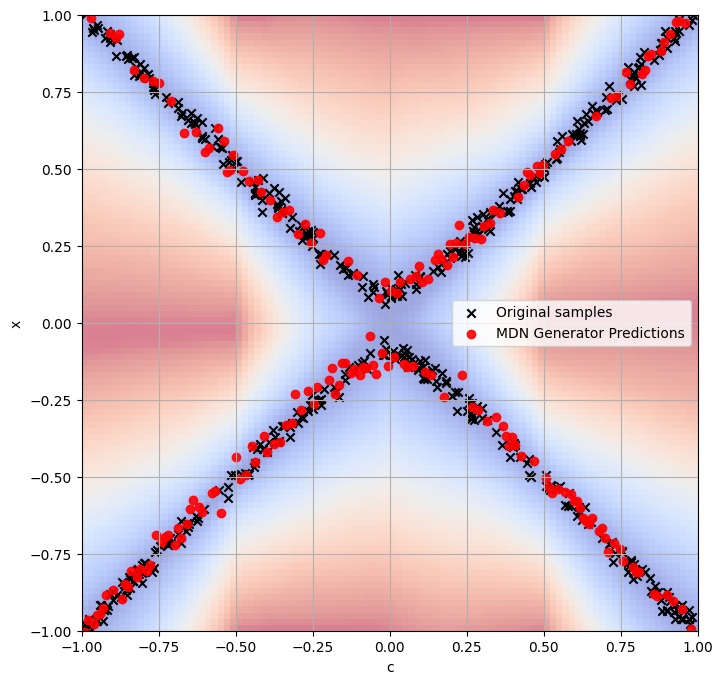


=== Training Run 3 ===
Epoch [1/100], Energy Loss: 3.4707, Generator Loss: -0.4993, Generator Energy Loss: -0.6089, Generator MDN Loss: 0.1096
Epoch [2/100], Energy Loss: 3.2846, Generator Loss: -1.4138, Generator Energy Loss: -1.4685, Generator MDN Loss: 0.0547
Epoch [3/100], Energy Loss: 2.9692, Generator Loss: -2.4911, Generator Energy Loss: -2.5132, Generator MDN Loss: 0.0221
Epoch [4/100], Energy Loss: 2.6916, Generator Loss: -2.9668, Generator Energy Loss: -2.9668, Generator MDN Loss: 0.0000
Epoch [5/100], Energy Loss: 2.4452, Generator Loss: -3.6499, Generator Energy Loss: -3.6453, Generator MDN Loss: -0.0046
Epoch [6/100], Energy Loss: 2.3829, Generator Loss: -3.7482, Generator Energy Loss: -3.7571, Generator MDN Loss: 0.0089
Epoch [7/100], Energy Loss: 2.2509, Generator Loss: -3.9760, Generator Energy Loss: -3.9589, Generator MDN Loss: -0.0171
Epoch [8/100], Energy Loss: 2.1527, Generator Loss: -4.0514, Generator Energy Loss: -4.0124, Generator MDN Loss: -0.0390
Epoch [9/100]

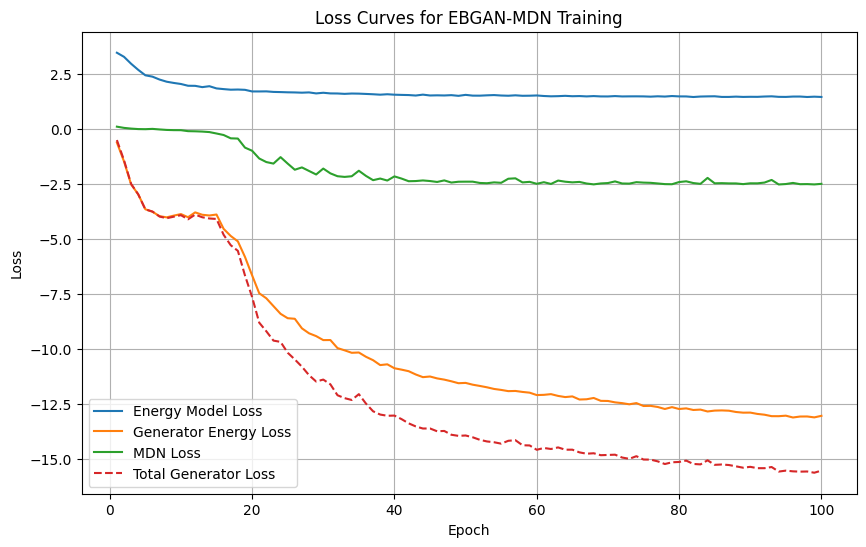

Run 3 - KL Divergence: 1.3235, Wasserstein Distance: 0.0059, Mode Coverage (%): 100.0, Avgerage Modes coveraged: 2.0


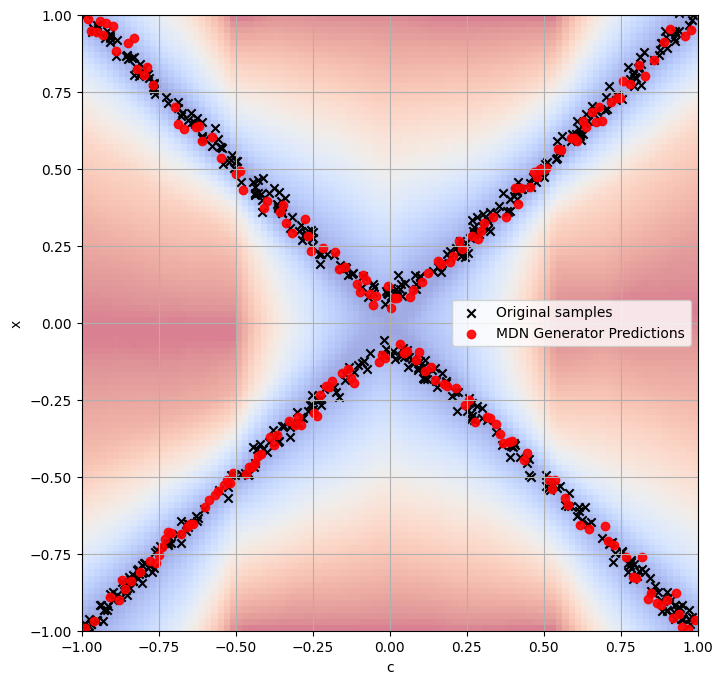


=== Training Run 4 ===
Epoch [1/100], Energy Loss: 3.4721, Generator Loss: -0.5218, Generator Energy Loss: -0.6647, Generator MDN Loss: 0.1429
Epoch [2/100], Energy Loss: 3.2463, Generator Loss: -1.7254, Generator Energy Loss: -1.7704, Generator MDN Loss: 0.0450
Epoch [3/100], Energy Loss: 2.8655, Generator Loss: -2.9827, Generator Energy Loss: -2.9944, Generator MDN Loss: 0.0117
Epoch [4/100], Energy Loss: 2.6347, Generator Loss: -3.8784, Generator Energy Loss: -3.8840, Generator MDN Loss: 0.0056
Epoch [5/100], Energy Loss: 2.4159, Generator Loss: -4.3599, Generator Energy Loss: -4.3457, Generator MDN Loss: -0.0143
Epoch [6/100], Energy Loss: 2.3256, Generator Loss: -4.3417, Generator Energy Loss: -4.3074, Generator MDN Loss: -0.0343
Epoch [7/100], Energy Loss: 2.2308, Generator Loss: -4.4650, Generator Energy Loss: -4.3467, Generator MDN Loss: -0.1183
Epoch [8/100], Energy Loss: 2.1167, Generator Loss: -4.4590, Generator Energy Loss: -4.3088, Generator MDN Loss: -0.1502
Epoch [9/100

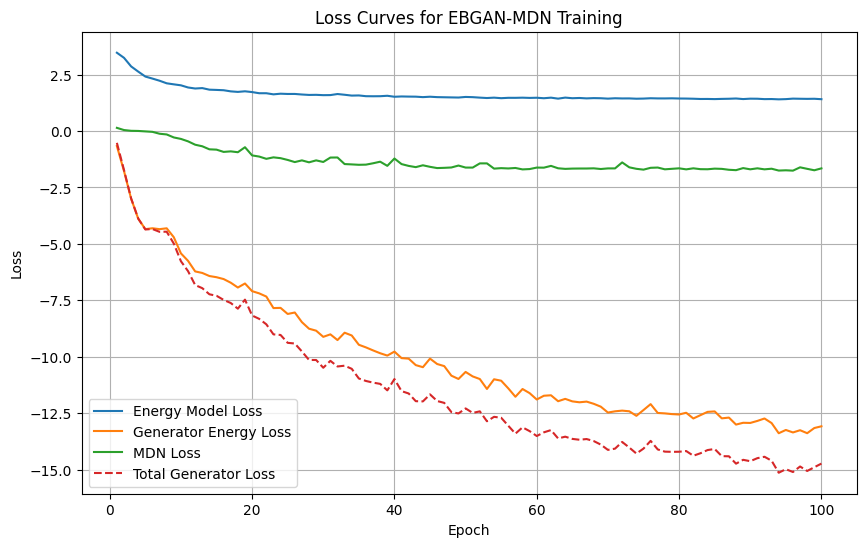

Run 4 - KL Divergence: 3.0418, Wasserstein Distance: 0.0089, Mode Coverage (%): 61.0, Avgerage Modes coveraged: 1.61


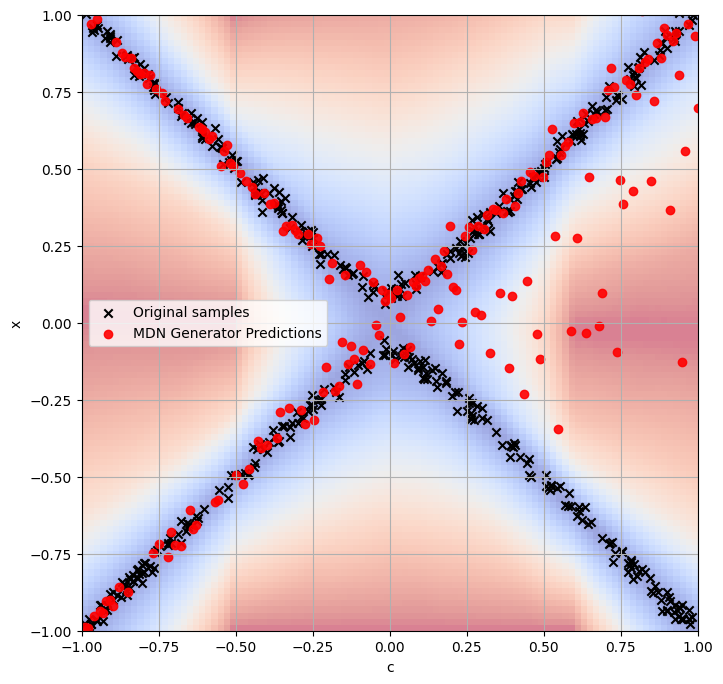


=== Training Run 5 ===
Epoch [1/100], Energy Loss: 3.4689, Generator Loss: -0.2646, Generator Energy Loss: -0.4110, Generator MDN Loss: 0.1464
Epoch [2/100], Energy Loss: 3.2313, Generator Loss: -1.6176, Generator Energy Loss: -1.6824, Generator MDN Loss: 0.0647
Epoch [3/100], Energy Loss: 2.8703, Generator Loss: -3.1538, Generator Energy Loss: -3.1851, Generator MDN Loss: 0.0313
Epoch [4/100], Energy Loss: 2.6099, Generator Loss: -3.9748, Generator Energy Loss: -3.9821, Generator MDN Loss: 0.0073
Epoch [5/100], Energy Loss: 2.4312, Generator Loss: -4.1776, Generator Energy Loss: -4.2042, Generator MDN Loss: 0.0266
Epoch [6/100], Energy Loss: 2.2965, Generator Loss: -4.7938, Generator Energy Loss: -4.7783, Generator MDN Loss: -0.0155
Epoch [7/100], Energy Loss: 2.1538, Generator Loss: -4.9073, Generator Energy Loss: -4.8997, Generator MDN Loss: -0.0076
Epoch [8/100], Energy Loss: 2.0867, Generator Loss: -4.7419, Generator Energy Loss: -4.7462, Generator MDN Loss: 0.0043
Epoch [9/100],

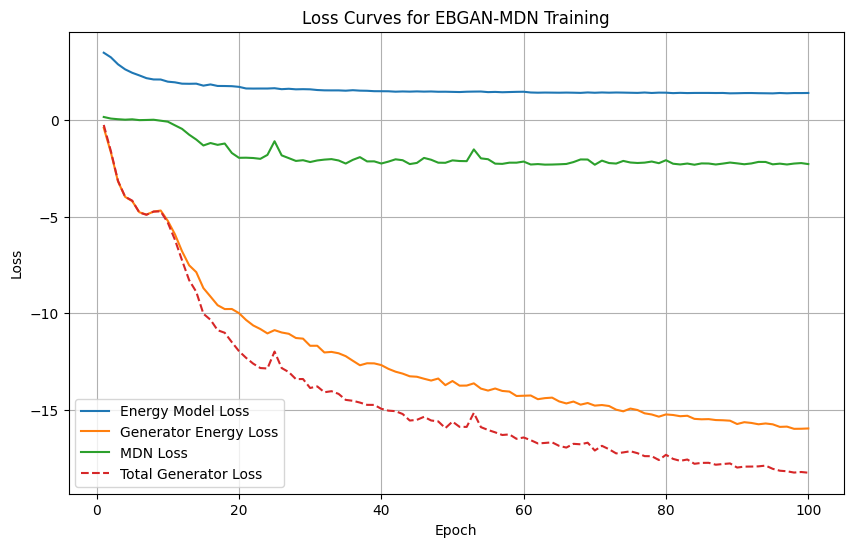

Run 5 - KL Divergence: 3.2176, Wasserstein Distance: 0.0079, Mode Coverage (%): 100.0, Avgerage Modes coveraged: 2.0


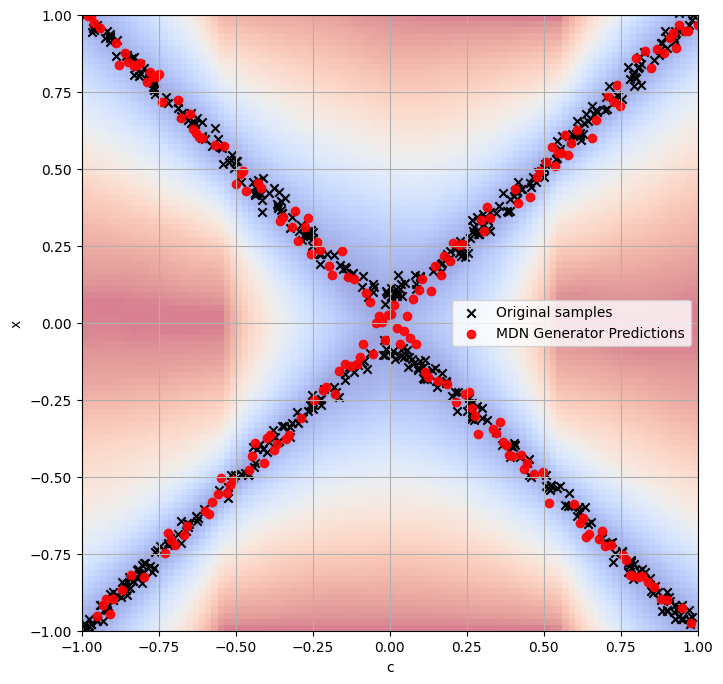

KL Divergence: 2.2387 ± 0.7505
Wasserstein Distance: 0.0076 ± 0.0010
Mode Coverage (%): 92.2000 ± 15.6000
Avgerage Modes coveraged: 1.9220 ± 0.1560


In [27]:
# Hyperparameters
num_gaussians = 2

latent_size = 1
hidden_size = 64

num_epochs = 100
batch_size = 32

neg_count = 32
repeat_energy_updates = 5

learning_rate_e = 0.001
learning_rate_g = 0.0005

epoch_num_eval = 100

# Configuration parameter 
alpha = 0
dynamic_scaling_true = False
min_scale = 0.1


metrics_results = train_and_evaluate(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_min=y_min,
    y_max=y_max,
    neg_count=neg_count,
    repeat_energy_updates=repeat_energy_updates,
    device=device,
    alpha=alpha,
    dynamic_scaling_true=dynamic_scaling_true,
    min_scale=min_scale,
    y_multi = y_multi,
    latent_size = latent_size,
    hidden_size = hidden_size,
    num_gaussians = num_gaussians,
    learning_rate_e = learning_rate_e,
    learning_rate_g = learning_rate_g
)

## Equal ratio Inclusion

In [39]:

from methods.ebgan import EnergyModel, generate_counter_samples
from methods.mdn import MDNGenerator, mdn_loss


# InfoNCE-style loss function with dynamic scaling
def info_nce_loss(energy_model, x, y, counter_samples, generator_samples, alpha):
    
    positive_energy = -energy_model(x, y)
    neg_energies = torch.stack([-energy_model(x, neg) for neg in counter_samples], dim=1)
    generator_energy = torch.stack([-energy_model(x, neg) for neg in generator_samples], dim=1)

    # Apply dynamic scaling to the generator term
    denominator = torch.logsumexp(
        torch.cat([positive_energy.unsqueeze(-1), neg_energies, generator_energy], dim=-1),
        dim=-1
    )
    return torch.mean(denominator - positive_energy)

def dynamic_scaling(epoch, total_epochs, min_scale=0.1):
    return max(1 - epoch / total_epochs, min_scale)


# Training loop combining energy model with MDN generator
def train_ebgan_mdn_test(dataloader, energy_model, generator, optimizer_e, optimizer_g, 
                    scheduler_e, scheduler_g, num_epochs, writer, 
                    y_min, y_max, neg_count, repeat_energy_updates, device, 
                    alpha = 1, dynamic_scaling_true = False,
                    min_scale = 0.1):
    energy_model.train()
    generator.train()
    # Initialize lists to track losses
    energy_losses = []
    generator_e_losses = []
    mdn_losses = []
    total_g_losses = []

    for epoch in range(num_epochs):
        epoch_e_loss = 0.0
        epoch_g_loss_e = 0.0
        epoch_g_loss_mdn = 0.0
        epoch_g_loss = 0.0
        batch_counter = 0
        
        if dynamic_scaling_true:
            alpha = dynamic_scaling(epoch, num_epochs, min_scale)
        
        for batch_x, batch_y in dataloader:
            x_input = batch_x.to(device)
            y_target = batch_y.to(device)

            for _ in range(repeat_energy_updates):
                # Draw noise samples
                fake_y_target = []
                
                for _ in range(neg_count):
                    z = torch.randn(x_input.size(0), generator.latent_size).to(device)
                    # Generate fake samples
                    fake_y_target.append(generator.sample(z, x_input))
                
                counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
                
                # Compute loss
                e_loss = info_nce_loss(energy_model, x_input, y_target, counter_samples, fake_y_target, alpha)
                
                # Backpropagation
                optimizer_e.zero_grad()
                e_loss.backward()
                optimizer_e.step()
                
                epoch_e_loss += e_loss.item()

            # Compute energy 
            z = torch.randn(x_input.size(0), generator.latent_size).to(device)
            fake_y_target = generator.sample(z, x_input)
            g_loss_e = energy_model(x_input, fake_y_target).mean()

            # Compute MDN loss
            log_pi, mu, sigma = generator(z, x_input)
            mdn_g_loss = mdn_loss(log_pi, mu, sigma, y_target)

            epoch_g_loss_e += g_loss_e.item()
            epoch_g_loss_mdn += mdn_g_loss.item()
            
            # Combined loss
            g_loss = g_loss_e + mdn_g_loss
            
            epoch_g_loss += g_loss.item()

            # Backpropagation
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()

            # Log losses
            if writer:
                writer.add_scalar('Loss/EnergyModel', e_loss.item(), epoch * len(dataloader) + batch_counter)
                writer.add_scalar('Loss/GeneratorE', g_loss_e.item(), epoch * len(dataloader) + batch_counter)
                writer.add_scalar('Loss/MDN', mdn_g_loss.item(), epoch * len(dataloader) + batch_counter)
                writer.add_scalar('Loss/Generator', g_loss.item(), epoch * len(dataloader) + batch_counter)
            
            batch_counter += 1
            
        scheduler_e.step()
        scheduler_g.step()
        avg_e_loss = epoch_e_loss / len(dataloader) / repeat_energy_updates
        avg_g_loss_e = epoch_g_loss_e / len(dataloader)
        avg_g_loss_mdn = epoch_g_loss_mdn / len(dataloader)
        avg_g_loss = epoch_g_loss / len(dataloader)
        
        # Store losses for plotting
        energy_losses.append(avg_e_loss)
        generator_e_losses.append(avg_g_loss_e)
        mdn_losses.append(avg_g_loss_mdn)
        total_g_losses.append(avg_g_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
                f"Energy Loss: {avg_e_loss:.4f}, "
                f"Generator Loss: {avg_g_loss:.4f}, "
                f"Generator Energy Loss: {avg_g_loss_e:.4f}, "
                f"Generator MDN Loss: {avg_g_loss_mdn:.4f}"
                )
        
        
    # Plot the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), energy_losses, label='Energy Model Loss')
    plt.plot(range(1, num_epochs + 1), generator_e_losses, label='Generator Energy Loss')
    plt.plot(range(1, num_epochs + 1), mdn_losses, label='MDN Loss')
    plt.plot(range(1, num_epochs + 1), total_g_losses, label='Total Generator Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves for EBGAN-MDN Training')
    plt.legend()
    plt.grid(True)
    plt.show()

In [40]:
def train_and_evaluate_test(num_trials, dataloader, test_x_vals, test_y_vals_transposed, 
                       num_epochs, y_min, y_max, 
                       neg_count, repeat_energy_updates, device, alpha, dynamic_scaling_true, min_scale, y_multi,
                       latent_size, hidden_size, num_gaussians, learning_rate_e, learning_rate_g
                       ):
    results = {"KL Divergence": [], "Wasserstein Distance": [], "Mode Coverage (%)": [], "Avgerage Modes coveraged": []}

    for trial in range(num_trials):
        print(f"\n=== Training Run {trial + 1} ===")
        
        ebgan_mdn_generator = MDNGenerator(latent_size, hidden_size, output_size, num_gaussians, condition_size).to(device)
        ebgan_energy_model = EnergyModel(condition_size, output_size, hidden_size).to(device)

        # Optimizer
        optimizer_ebgan_e = optim.Adam(ebgan_energy_model.parameters(), lr=learning_rate_e)
        optimizer_ebgan_g = optim.Adam(ebgan_mdn_generator.parameters(), lr=learning_rate_g)
        scheduler_e = optim.lr_scheduler.StepLR(optimizer_ebgan_e, step_size=20, gamma=0.5)
        scheduler_g = optim.lr_scheduler.StepLR(optimizer_ebgan_g, step_size=20, gamma=0.5)
        
        # Train the model
        train_ebgan_mdn_test(dataloader, ebgan_energy_model, ebgan_mdn_generator, optimizer_ebgan_e, optimizer_ebgan_g, 
                        scheduler_e, scheduler_g, num_epochs, None, y_min, y_max, neg_count, 
                        repeat_energy_updates, device, alpha, dynamic_scaling_true, min_scale)

        # Flatten the true test y values for metric computation
        true_y_flat = np.array(test_y_vals_transposed).reshape(-1, len(test_x_vals)).T

        # Compute metrics  
        metrics = compute_metrics(ebgan_mdn_generator, test_x_vals, true_y_flat , y_multi, K = 10, num_bins=50, tolerance=TOLERANCE)
        for key in results.keys():
            results[key].append(metrics[key])

        print(f"Run {trial + 1} - KL Divergence: {metrics["KL Divergence"]:.4f}, Wasserstein Distance: {metrics["Wasserstein Distance"]:.4f}, Mode Coverage (%): {metrics["Mode Coverage (%)"]}, Avgerage Modes coveraged: {metrics["Avgerage Modes coveraged"]}")
        
        evaluate_model(ebgan_energy_model, ebgan_mdn_generator, num_epochs, ebgan_mdn_generator.latent_size, device, trial)
    # Compute averages and standard deviations
    for metric, values in results.items():
        avg = np.mean(values)
        std = np.std(values)
        print(f"{metric}: {avg:.4f} ± {std:.4f}")

    return results


=== Training Run 1 ===
Epoch [1/100], Energy Loss: 4.0872, Generator Loss: 0.5014, Generator Energy Loss: 0.3243, Generator MDN Loss: 0.1771
Epoch [2/100], Energy Loss: 3.8980, Generator Loss: 0.7098, Generator Energy Loss: 0.6315, Generator MDN Loss: 0.0783
Epoch [3/100], Energy Loss: 3.5654, Generator Loss: 0.6805, Generator Energy Loss: 0.6313, Generator MDN Loss: 0.0492
Epoch [4/100], Energy Loss: 3.2238, Generator Loss: 0.8039, Generator Energy Loss: 0.7455, Generator MDN Loss: 0.0584
Epoch [5/100], Energy Loss: 3.0210, Generator Loss: 1.1995, Generator Energy Loss: 1.1700, Generator MDN Loss: 0.0295
Epoch [6/100], Energy Loss: 2.8587, Generator Loss: 1.6800, Generator Energy Loss: 1.6588, Generator MDN Loss: 0.0212
Epoch [7/100], Energy Loss: 2.7513, Generator Loss: 2.2219, Generator Energy Loss: 2.2192, Generator MDN Loss: 0.0027
Epoch [8/100], Energy Loss: 2.6810, Generator Loss: 2.9044, Generator Energy Loss: 2.9141, Generator MDN Loss: -0.0097
Epoch [9/100], Energy Loss: 2.6

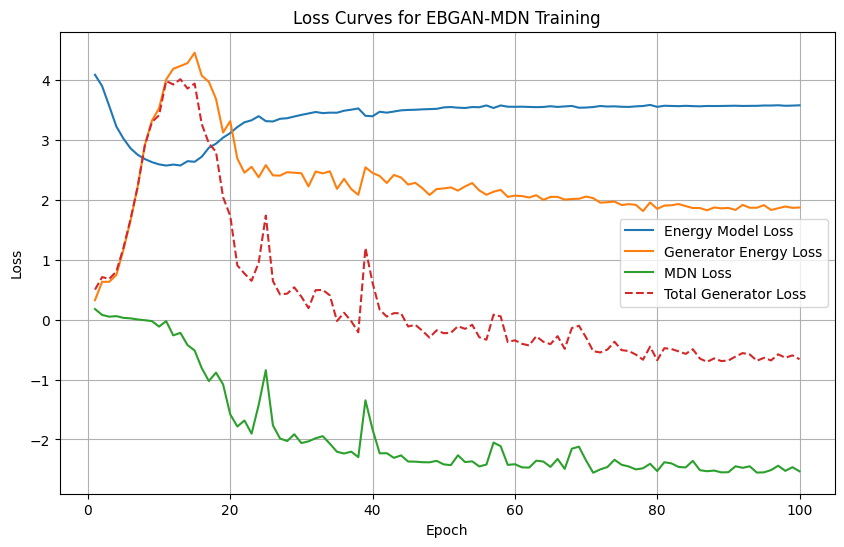

Run 1 - KL Divergence: 3.1862, Wasserstein Distance: 0.0080, Mode Coverage (%): 100.0, Avgerage Modes coveraged: 2.0


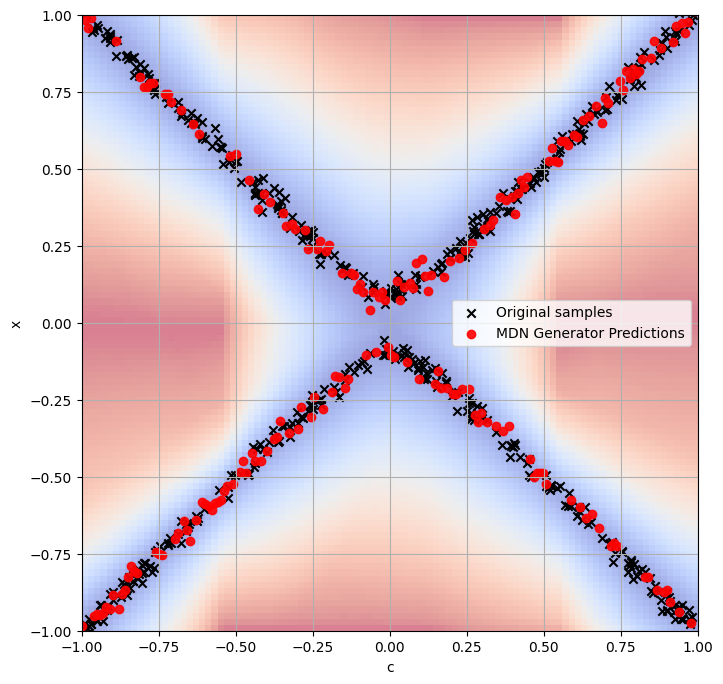


=== Training Run 2 ===
Epoch [1/100], Energy Loss: 4.0968, Generator Loss: 0.6203, Generator Energy Loss: 0.3949, Generator MDN Loss: 0.2254
Epoch [2/100], Energy Loss: 3.9090, Generator Loss: 0.6612, Generator Energy Loss: 0.5469, Generator MDN Loss: 0.1143
Epoch [3/100], Energy Loss: 3.6212, Generator Loss: 0.2635, Generator Energy Loss: 0.2218, Generator MDN Loss: 0.0417
Epoch [4/100], Energy Loss: 3.3411, Generator Loss: -0.1747, Generator Energy Loss: -0.2075, Generator MDN Loss: 0.0327
Epoch [5/100], Energy Loss: 3.0870, Generator Loss: -0.2282, Generator Energy Loss: -0.2629, Generator MDN Loss: 0.0347
Epoch [6/100], Energy Loss: 2.9319, Generator Loss: 0.4382, Generator Energy Loss: 0.4075, Generator MDN Loss: 0.0307
Epoch [7/100], Energy Loss: 2.8189, Generator Loss: 0.8182, Generator Energy Loss: 0.7931, Generator MDN Loss: 0.0251
Epoch [8/100], Energy Loss: 2.7467, Generator Loss: 1.4259, Generator Energy Loss: 1.4602, Generator MDN Loss: -0.0342
Epoch [9/100], Energy Loss:

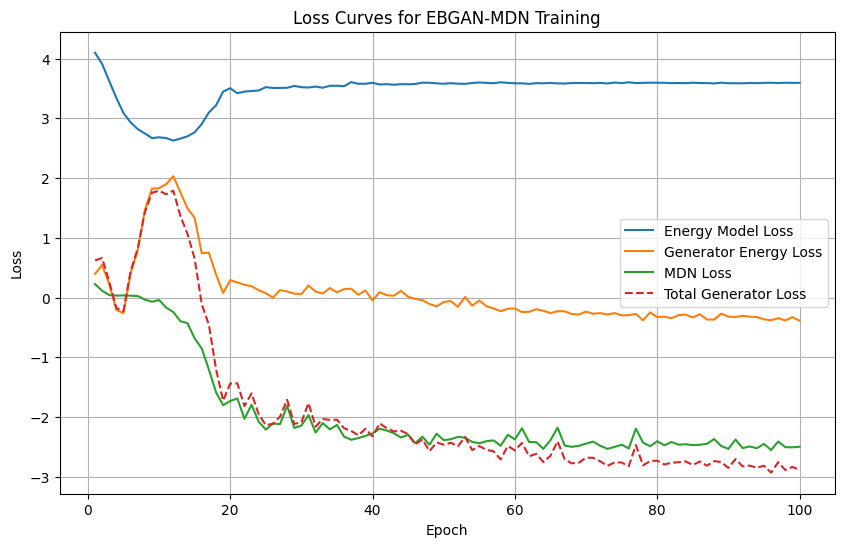

Run 2 - KL Divergence: 2.3524, Wasserstein Distance: 0.0076, Mode Coverage (%): 100.0, Avgerage Modes coveraged: 2.0


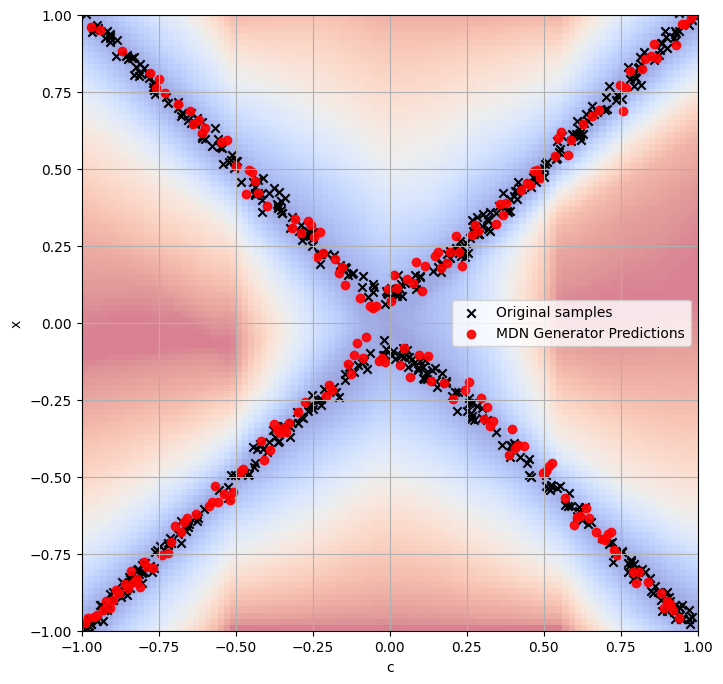


=== Training Run 3 ===
Epoch [1/100], Energy Loss: 4.0695, Generator Loss: 0.6660, Generator Energy Loss: 0.4391, Generator MDN Loss: 0.2269
Epoch [2/100], Energy Loss: 3.8707, Generator Loss: 0.9388, Generator Energy Loss: 0.8099, Generator MDN Loss: 0.1288
Epoch [3/100], Energy Loss: 3.5675, Generator Loss: 0.8115, Generator Energy Loss: 0.7556, Generator MDN Loss: 0.0559
Epoch [4/100], Energy Loss: 3.2201, Generator Loss: 0.8112, Generator Energy Loss: 0.7419, Generator MDN Loss: 0.0693
Epoch [5/100], Energy Loss: 2.9749, Generator Loss: 1.3868, Generator Energy Loss: 1.2826, Generator MDN Loss: 0.1041
Epoch [6/100], Energy Loss: 2.8434, Generator Loss: 2.1071, Generator Energy Loss: 2.0452, Generator MDN Loss: 0.0619
Epoch [7/100], Energy Loss: 2.7145, Generator Loss: 2.6319, Generator Energy Loss: 2.5848, Generator MDN Loss: 0.0471
Epoch [8/100], Energy Loss: 2.6221, Generator Loss: 3.6044, Generator Energy Loss: 3.6059, Generator MDN Loss: -0.0015
Epoch [9/100], Energy Loss: 2.6

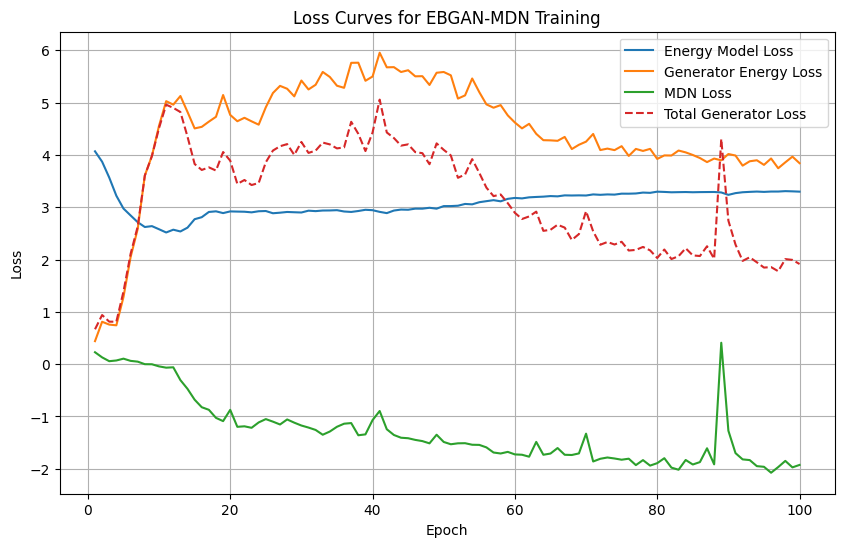

Run 3 - KL Divergence: 1.6817, Wasserstein Distance: 0.0050, Mode Coverage (%): 93.0, Avgerage Modes coveraged: 1.93


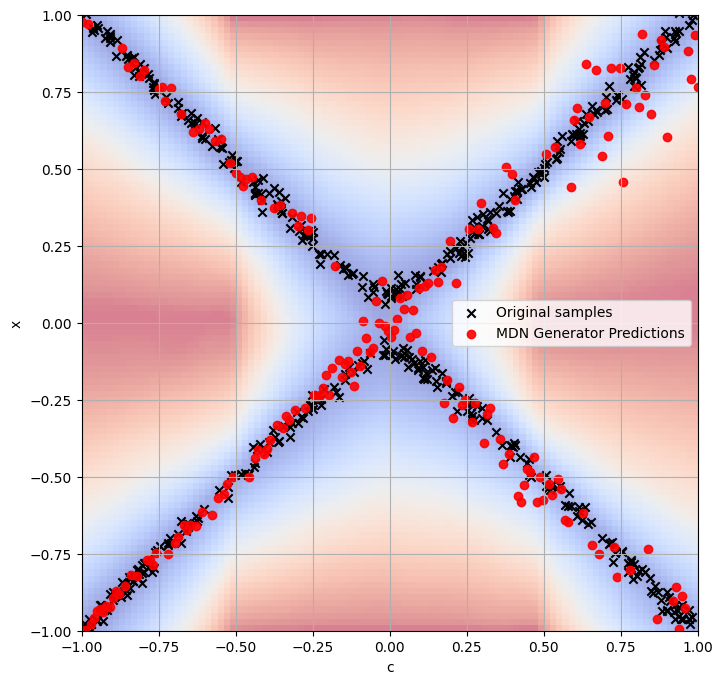


=== Training Run 4 ===
Epoch [1/100], Energy Loss: 4.1045, Generator Loss: 0.5367, Generator Energy Loss: 0.4219, Generator MDN Loss: 0.1148
Epoch [2/100], Energy Loss: 3.9528, Generator Loss: 0.6856, Generator Energy Loss: 0.6710, Generator MDN Loss: 0.0145
Epoch [3/100], Energy Loss: 3.6489, Generator Loss: 0.8761, Generator Energy Loss: 0.8530, Generator MDN Loss: 0.0231
Epoch [4/100], Energy Loss: 3.3087, Generator Loss: 1.4964, Generator Energy Loss: 1.5012, Generator MDN Loss: -0.0047
Epoch [5/100], Energy Loss: 3.0724, Generator Loss: 2.3159, Generator Energy Loss: 2.3627, Generator MDN Loss: -0.0468
Epoch [6/100], Energy Loss: 2.9246, Generator Loss: 3.2743, Generator Energy Loss: 3.4034, Generator MDN Loss: -0.1291
Epoch [7/100], Energy Loss: 2.8470, Generator Loss: 4.4335, Generator Energy Loss: 4.1948, Generator MDN Loss: 0.2387
Epoch [8/100], Energy Loss: 2.8170, Generator Loss: 4.7027, Generator Energy Loss: 4.9597, Generator MDN Loss: -0.2570
Epoch [9/100], Energy Loss: 

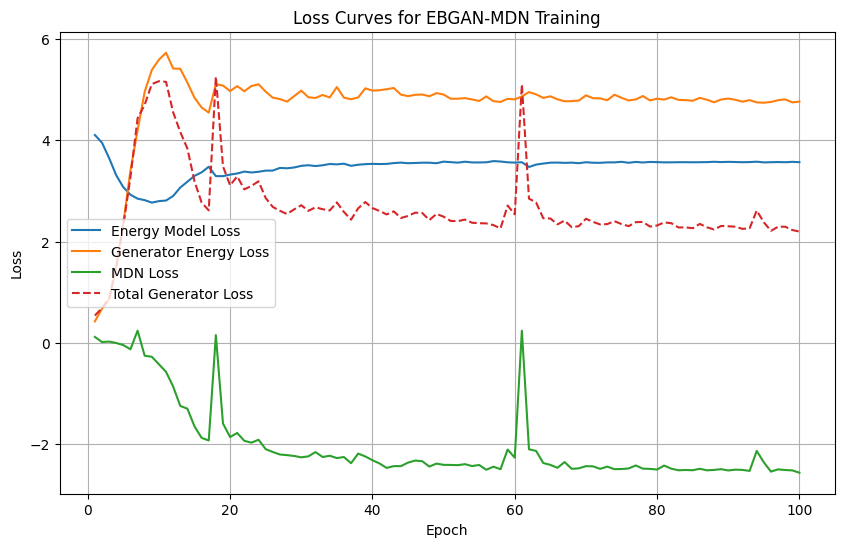

Run 4 - KL Divergence: 1.3568, Wasserstein Distance: 0.0078, Mode Coverage (%): 100.0, Avgerage Modes coveraged: 2.0


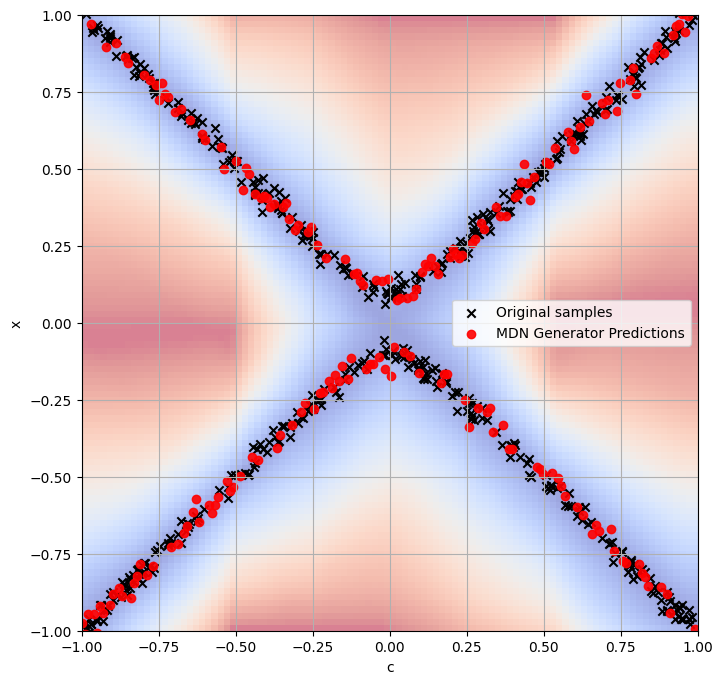


=== Training Run 5 ===
Epoch [1/100], Energy Loss: 4.0900, Generator Loss: 0.6901, Generator Energy Loss: 0.4862, Generator MDN Loss: 0.2039
Epoch [2/100], Energy Loss: 3.8760, Generator Loss: 1.1531, Generator Energy Loss: 1.0688, Generator MDN Loss: 0.0842
Epoch [3/100], Energy Loss: 3.5412, Generator Loss: 1.5329, Generator Energy Loss: 1.5050, Generator MDN Loss: 0.0279
Epoch [4/100], Energy Loss: 3.2148, Generator Loss: 2.4521, Generator Energy Loss: 2.3982, Generator MDN Loss: 0.0539
Epoch [5/100], Energy Loss: 2.9801, Generator Loss: 3.3338, Generator Energy Loss: 3.2922, Generator MDN Loss: 0.0416
Epoch [6/100], Energy Loss: 2.8062, Generator Loss: 4.4131, Generator Energy Loss: 4.4015, Generator MDN Loss: 0.0116
Epoch [7/100], Energy Loss: 2.6936, Generator Loss: 5.4180, Generator Energy Loss: 5.3982, Generator MDN Loss: 0.0198
Epoch [8/100], Energy Loss: 2.6085, Generator Loss: 6.4458, Generator Energy Loss: 6.4626, Generator MDN Loss: -0.0168
Epoch [9/100], Energy Loss: 2.5

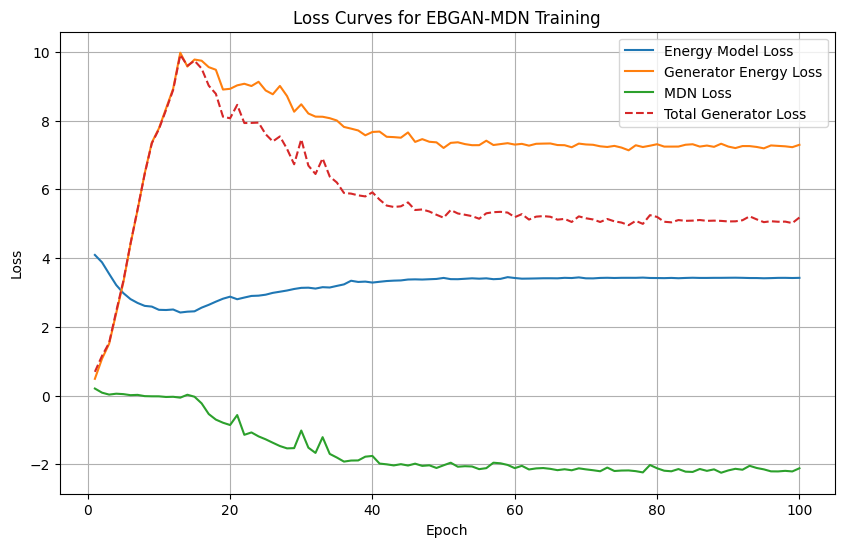

Run 5 - KL Divergence: 0.8866, Wasserstein Distance: 0.0074, Mode Coverage (%): 96.0, Avgerage Modes coveraged: 1.96


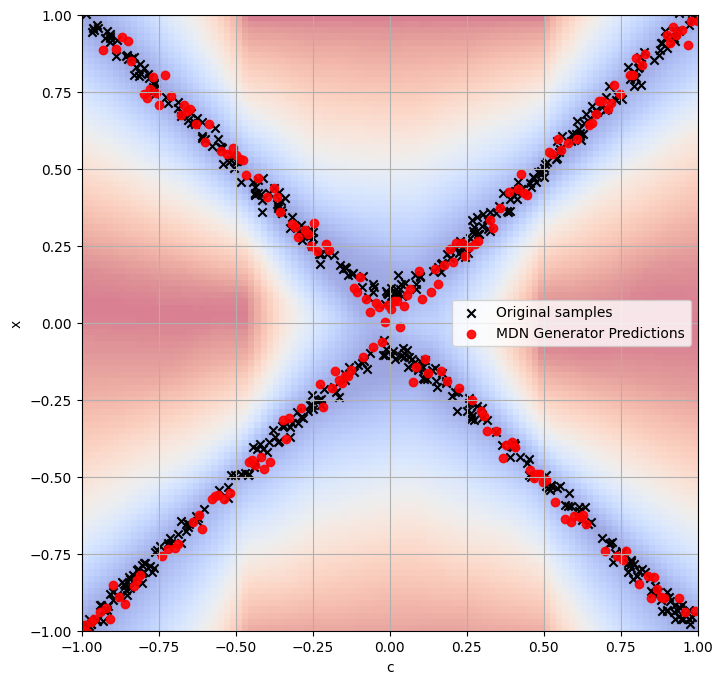

KL Divergence: 1.8928 ± 0.8036
Wasserstein Distance: 0.0072 ± 0.0011
Mode Coverage (%): 97.8000 ± 2.8566
Avgerage Modes coveraged: 1.9780 ± 0.0286


In [41]:
# Hyperparameters
num_gaussians = 2

latent_size = 1
hidden_size = 64

num_epochs = 100
batch_size = 32

neg_count = 32
repeat_energy_updates = 5

learning_rate_e = 0.001
learning_rate_g = 0.0005

epoch_num_eval = 100

# Configuration parameter 
alpha = 1
dynamic_scaling_true = False
min_scale = 0.1


metrics_results = train_and_evaluate_test(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_min=y_min,
    y_max=y_max,
    neg_count=neg_count,
    repeat_energy_updates=repeat_energy_updates,
    device=device,
    alpha=alpha,
    dynamic_scaling_true=dynamic_scaling_true,
    min_scale=min_scale,
    y_multi = y_multi,
    latent_size = latent_size,
    hidden_size = hidden_size,
    num_gaussians = num_gaussians,
    learning_rate_e = learning_rate_e,
    learning_rate_g = learning_rate_g
)